<a href="https://colab.research.google.com/github/StefanoBoeira/StefanoBoeira/blob/main/C%C3%B3pia_de_(x)_ULTIMO_de_NOVO_DIARIO_telemetria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SALA DE SITUAÇÃO RS

# https://plotly.com/python/maps/

In [2]:
!pip install yfinance

In [3]:
!pip install geopandas

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
import matplotlib as mpl
from pylab import *
from datetime import datetime, timedelta, date
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
from google.colab import drive
from google.colab import files
import geopandas as gpd
import csv
import plotly.graph_objects as go
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
import yfinance as yf
from collections import OrderedDict
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.dates as mdates
import json

warnings.simplefilter(action='ignore', category=FutureWarning)
# Warning-causing lines of code here

warnings.filterwarnings("ignore", category=DeprecationWarning)


In [5]:
drive.mount('/content/drive')
diretorio = '/content/drive/My Drive/Telemetria_climatempo/'

Mounted at /content/drive


In [6]:
dias = 1

delta = timedelta(days = dias)

now = datetime.now()

first = now - delta

dataFim = now.strftime("%d/%m/%Y")
dataInicio = first.strftime("%d/%m/%Y")

hora_rodada = str(max(0, int(now.strftime("%H"))-3))

print("Período: ", dataInicio, "-", dataFim, '(',hora_rodada,'h)')

Período:  01/07/2024 - 02/07/2024 ( 10 h)


In [7]:
bacias_sf = gpd.read_file(diretorio + "shapes/Bacias_RS_SEMA.shp", encoding = 'ISO-8859-1')
rios_sf = gpd.read_file(diretorio + "shapes/RIOS_RS.shp", encoding = 'ISO-8859-1')
RS = gpd.read_file(diretorio + "shapes/Limite_RS.shp", encoding = 'ISO-8859-1')
bacia_uru = gpd.read_file(diretorio + "shapes/Uruguai_RS.shp", encoding = 'ISO-8859-1')
lagos = gpd.read_file(diretorio + "shapes/Grandes_Lagos.shp", encoding = 'ISO-8859-1')

In [8]:
cotas = pd.read_excel(diretorio + 'COTAS_monitoramento3.xlsx')
cotas['Codigo'] = cotas['Codigo'].astype(int)

In [9]:
# Load ANA inventary
with open(diretorio + 'Inventario_Telemetria.xml', 'r', encoding="utf-8") as f:
    inv = f.read()

inventario = BeautifulSoup(inv, "xml")

In [10]:
planilha = pd.DataFrame(columns=['Rio','Codigo','Nome', 'Lat',
                                 'Lon' , 'Precipitação acumulada 24h (mm)',
                                 'Nível ontem','Nível atual (m)', 'Tendencia',
                                 'Tendencia_cor', 'Coeficiente angular',
                                 'Status', 'Status_cor'])

planilha['Codigo'] = planilha['Codigo'].astype(int)

In [11]:
# Initialize the pandas DataFrame and the lists
inventario_DATAFRAME = pd.DataFrame()
nomes = []
codigos = []
lat = []
lon = []
muni = []
rio = []

for table in inventario.select('Table'):

  nomes.append('N/A' if table.select_one('NomeEstacao') is None else table.select_one('NomeEstacao').get_text())
  codigos.append('N/A' if table.select_one('CodEstacao') is None else table.select_one('CodEstacao').get_text())
  lat.append('N/A' if table.select_one('Latitude') is None else table.select_one('Latitude').get_text())
  lon.append('N/A' if table.select_one('Longitude') is None else table.select_one('Longitude').get_text())
  muni.append('SEM NOME MUNICIPIO' if table.select_one('Municipio-UF') is None else table.select_one('Municipio-UF').get_text())
  rio.append('N/A' if table.select_one('NomeRio') is None else table.select_one('NomeRio').get_text())

# Construct the DataFrame from the populated lists
inventario_DATAFRAME['Nomes'] = pd.Series(nomes)
inventario_DATAFRAME['Codigos'] = pd.Series(codigos)
inventario_DATAFRAME['Lat'] = pd.Series(lat)
inventario_DATAFRAME['Lon'] = pd.Series(lon)
inventario_DATAFRAME['Municipio'] = pd.Series(muni)
inventario_DATAFRAME['NomeRio'] = pd.Series(rio)

# Iterate over the 'muni' list and add the corresponding code to 'RS_codigos' if the last two characters of the municipality are 'RS'
RS_codigos = [codigos[i] for i in range(len(muni)) if muni[i][-2:] == 'RS']

In [12]:
# estacoes prioritarias monitoramento
stations_monitora = [87399000, 87401750, 87376000, 87380000, 87382000, 87160000, 87165000, 87230000,
                      87170000, 87270000, 86472600, 86510000, 86879300, 86881000, 86950000, 85400000, 85642000,
                      85900000, 87450004, 87444000, 72870900, 75230000, 76750000, 76310000, 76560000, 74100000,
                      74329000, 74720000, 74800000, 75550000, 75780000, 75900000, 77150000, 77500000, 79400000,
                      87905000, 88260000, 88810100, 87991100, 87921000, 87955000, 87980000]

stations_monitora2 = [str(x) for x in stations_monitora]

# estacoes de SC na bacia do Uruguai
SC_stations = [74830000, 74423080, 74400080, 74400000, 74329000,
74324000, 74323000, 74322000, 74320000, 74315000, 74314980, 74314970, 74300200,
74300000, 74295000, 74201000, 74200980, 74200900, 74200500, 74050000, 73960000,
73900000, 73892000, 73890000, 73825000, 73819000, 73800000, 73790000, 73770000,
73712000, 73710000, 73699000, 73698500, 73694000, 73693800, 73693700, 73693500,
73692500, 73692200, 73692100, 73691000, 73690030, 73680900, 73680800, 73675000,
73674500, 73660000, 73658000, 73630000, 73620000, 73600700, 73600600, 73600550,
73600400, 73600390, 73600200, 73582900, 73582500, 73582000, 73571500, 73571000,
73570000, 73569000, 73560000, 73558000, 73553000, 73552000, 73509000,
73340000, 73339000, 73335000, 73334500, 73331800, 73331000,
73330250, 73330200, 73318000, 73317000, 73310000, 73290100, 73251000,
73250500, 73250000, 73249000, 73204000, 73203200, 73203000, 73200080,
73170000, 73100000, 72880000, 72870200, 72870100, 72860080,
72860000, 72849000, 72818000, 72817000, 72816000, 72815000, 72810000, 72806000,
72715000, 72700000, 72690080, 72101000, 71900000, 71890500,
71840000, 71740000, 71700000, 71655000, 71647000, 71645000, 71644000, 71621500,
71621000, 71540000, 71497000, 71388600, 71388000, 71386500,
71386000, 71385400, 71383300, 71380500, 71380450, 71350001, 71325000,
71300000, 71200000, 70610000, 70600000, 70305000, 70110000]

SC_stations2 = [str(x) for x in SC_stations]

#contatena listas
stations_ordem = stations_monitora2 + RS_codigos + SC_stations2

stations_ordem = [x.zfill(8) for x in stations_ordem]

stations = list(dict.fromkeys(stations_ordem))

print('Estacoes a serem analisadas: ')
print(len(stations))

Estacoes a serem analisadas: 
651


In [13]:
# # Cria uma lista de códigos a serem removidos
# codigos_a_remover = ['79200010', '88050010', '86101000', '85360050', '85360100'

#                      ]

# # Remove os códigos da lista stations
# stations = [codigo for codigo in stations if codigo not in codigos_a_remover]

# # Imprime a nova lista de estações
# print('Estações após a remoção:')
# print(len(stations))
# print("-")

# for station in sorted(stations):
#   print(station)

0.2%;PASSO DAS CANOAS - AUXILIAR;87399000;RIO GRAVATAÍ;GRAVATAÍ-RS;Chuva:0.0;Nível ontem:4.3;Nível hoje:4.17;ALERTA;ESTÁVEL


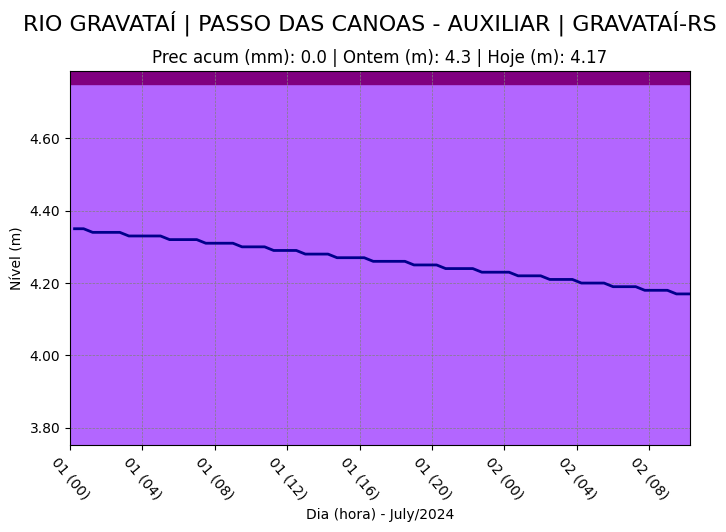

0.3%;CORSAN ALVORADA;87401750;RIO GRAVATAÍ;ALVORADA-RS;Chuva:0.0;Nível ontem:3.95;Nível hoje:3.82;ALERTA;ESTÁVEL


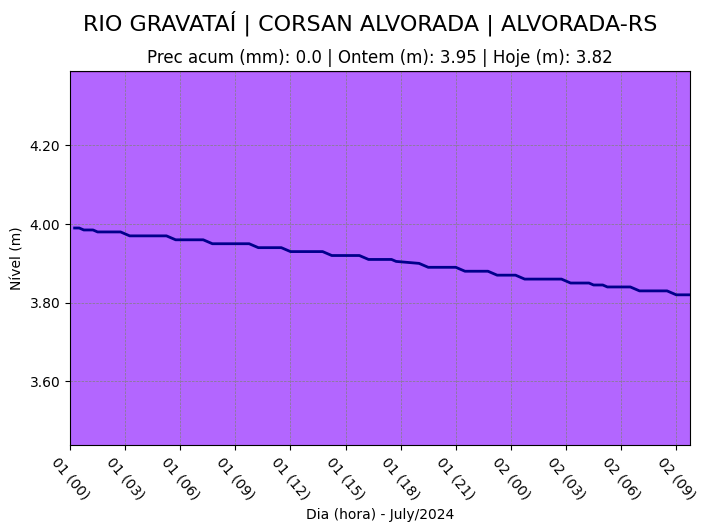

0.5%;FOZ DO PARANHANA;87376000;RIO DOS SINOS;TAQUARA-RS;Chuva:0.2;Nível ontem:3.49;Nível hoje:2.96;NORMAL;DECLÍNIO


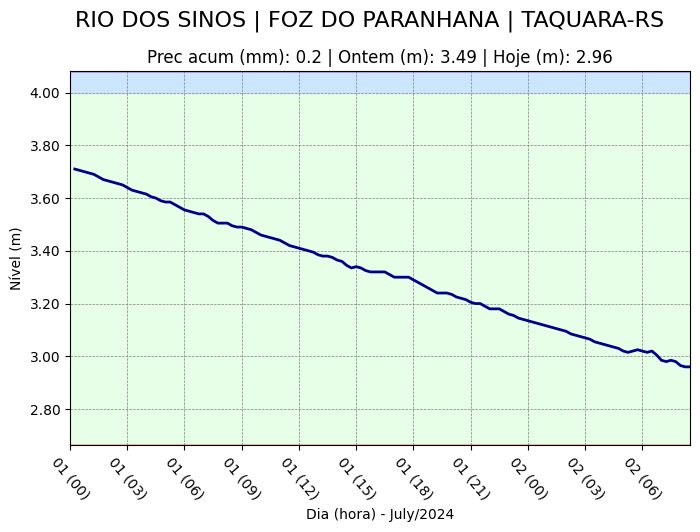

0.6%;CAMPO BOM;87380000;RIO DOS SINOS;CAMPO BOM-RS;Chuva:0.2;Nível ontem:5.88;Nível hoje:5.54;NORMAL;ESTÁVEL


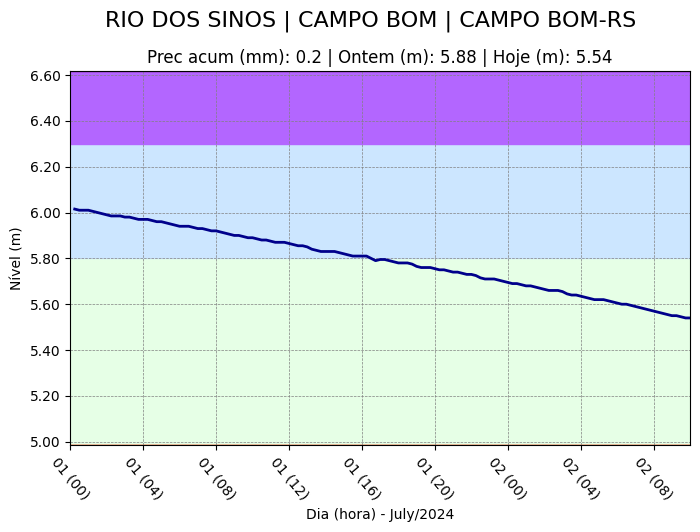

0.8%;SÃO LEOPOLDO;87382000;RIO DOS SINOS;SÃO LEOPOLDO-RS;Chuva:0.0;Nível ontem:4.25;Nível hoje:4.07;ATENÇÃO;ESTÁVEL


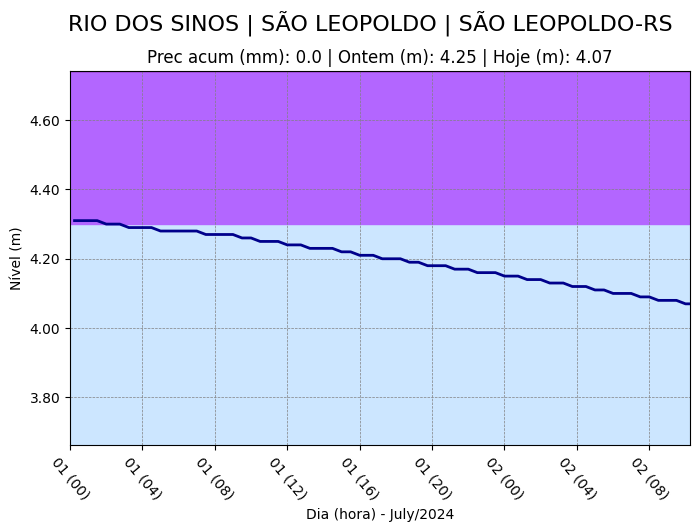

0.9%;NOVA PALMIRA;87160000;RIO CAÍ;CAXIAS DO SUL-RS;Chuva:0.2;Nível ontem:2.36;Nível hoje:2.3;ATENÇÃO;ESTÁVEL


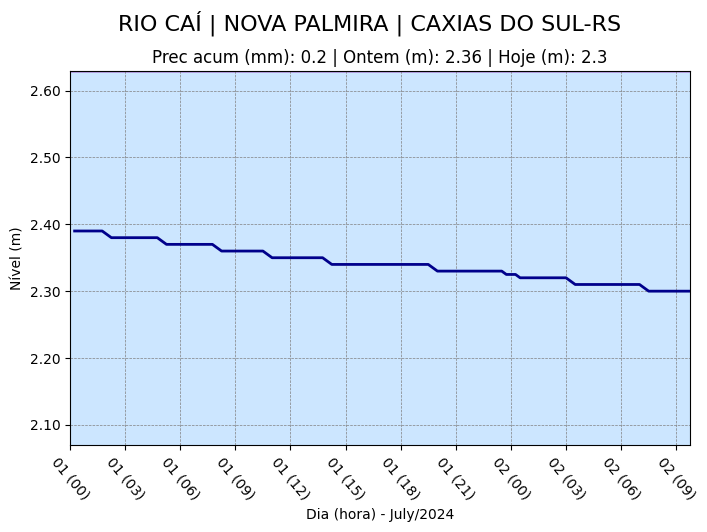

1.1%;FELIZ;87165000;RIO CAÍ;FELIZ-RS;sem dados
1.2%;COSTA DO RIO CADEIA - MONTANTE;87230000;RIO CADEIA;SÃO SEBASTIÃO DO CAÍ-RS;Chuva:0.2;Nível ontem:2.27;Nível hoje:1.18;NORMAL;ESTÁVEL


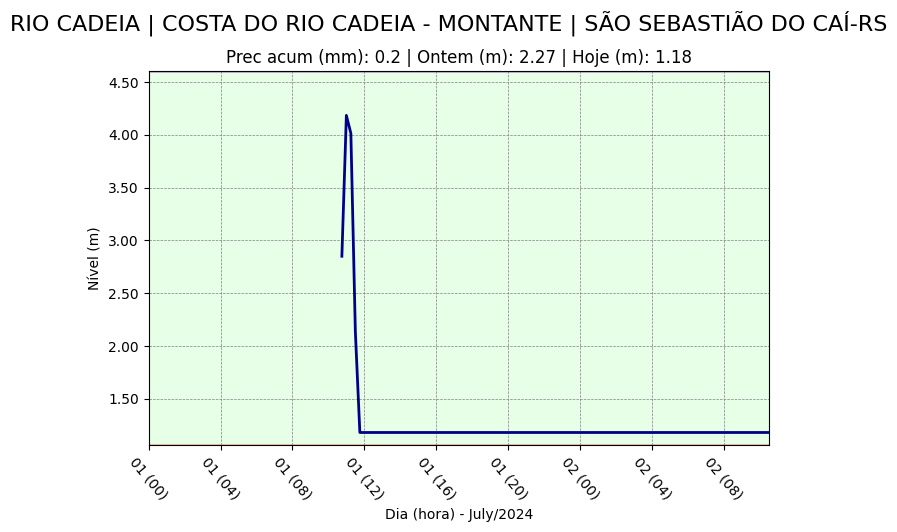

1.4%;BARCA DO CAÍ;87170000;RIO CAÍ;SÃO SEBASTIÃO DO CAÍ-RS;sem dados
1.5%;PASSO MONTENEGRO;87270000;RIO CAÍ;MONTENEGRO-RS;sem dados
1.7%;SANTA TEREZA;86472600;RIO TAQUARI;SANTA TEREZA-RS;Chuva:0.0;Nível ontem:4.34;Nível hoje:4.25;NORMAL;DECLÍNIO


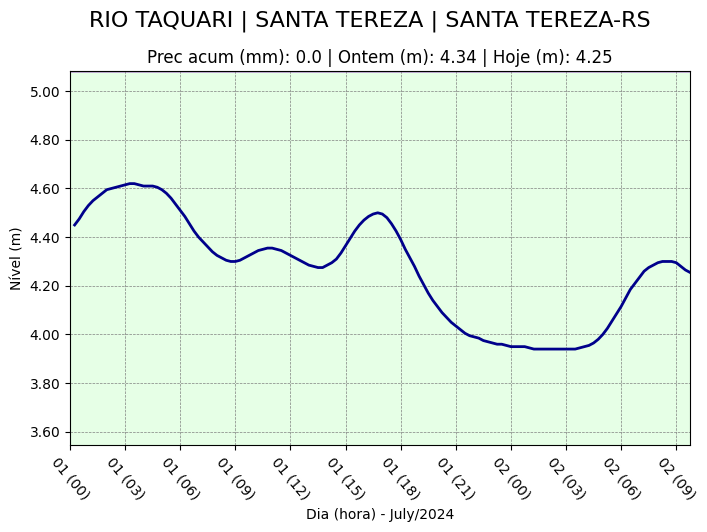

1.8%;MUÇUM;86510000;RIO TAQUARI;MUÇUM-RS;Chuva:0.0;Nível ontem:4.24;Nível hoje:3.99;NORMAL;ELEVAÇÃO


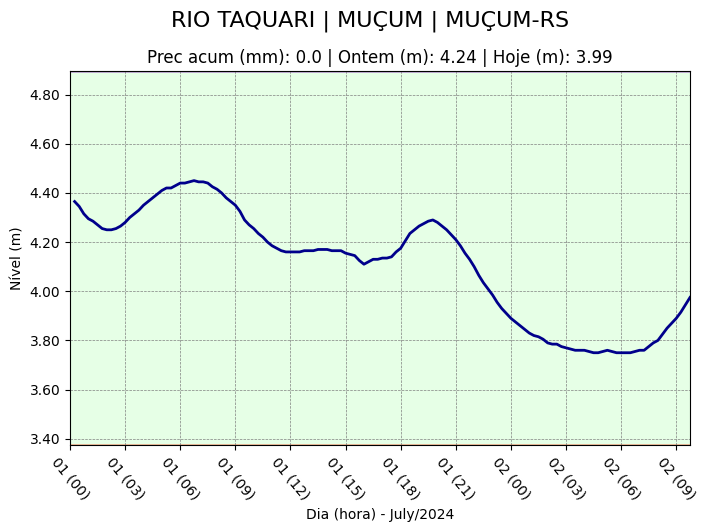

2.0%;ESTRELA;86879300;RIO TAQUARI;ESTRELA-RS;Chuva:0.0;Nível ontem:13.4;Nível hoje:12.97;NORMAL;DECLÍNIO


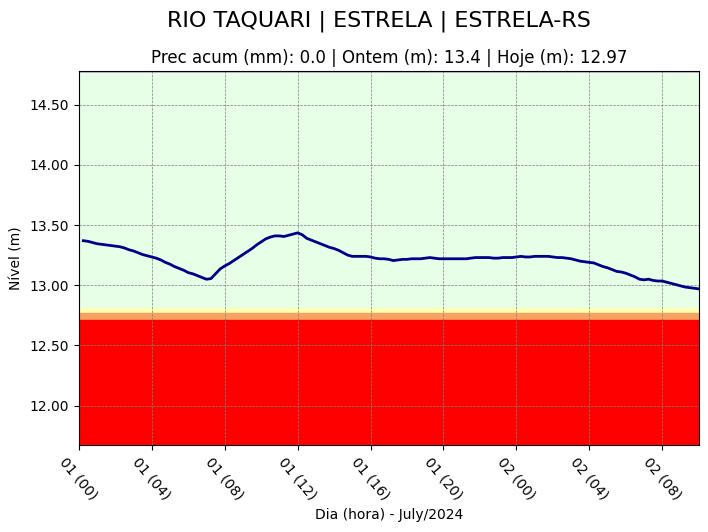

2.2%;BOM RETIRO DO SUL - MONTANTE;86881000;RIO TAQUARI;BOM RETIRO DO SUL-RS;Chuva:0.0;Nível ontem:5.68;Nível hoje:5.33;NORMAL;ESTÁVEL


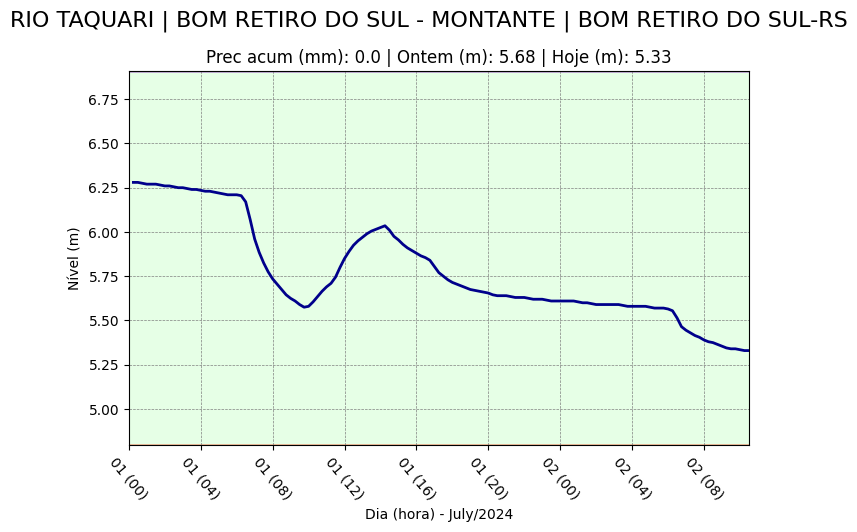

2.3%;TAQUARI;86950000;RIO TAQUARI;TAQUARI-RS;Chuva:0.0;Nível ontem:5.65;Nível hoje:5.21;ATENÇÃO;DECLÍNIO


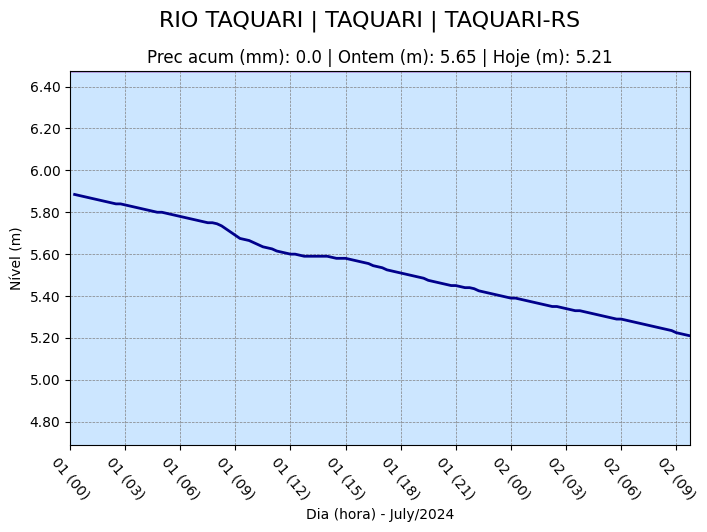

2.5%;DONA FRANCISCA;85400000;RIO JACUÍ;DONA FRANCISCA-RS;Chuva:0.0;Nível ontem:3.61;Nível hoje:3.44;ATENÇÃO;DECLÍNIO


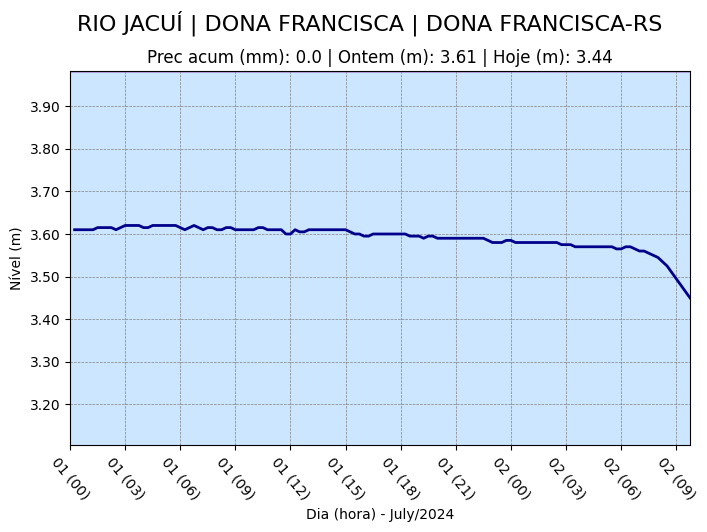

2.6%;PASSO SÃO LOURENÇO;85642000;RIO JACUÍ;CACHOEIRA DO SUL-RS;Chuva:0.2;Nível ontem:6.73;Nível hoje:5.87;NORMAL;DECLÍNIO


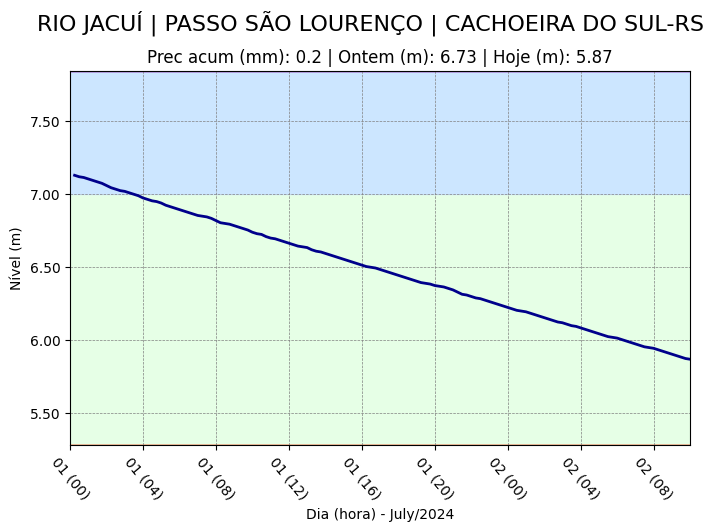

2.8%;RIO PARDO;85900000;RIO JACUÍ;RIO PARDO-RS;Chuva:0.2;Nível ontem:9.9;Nível hoje:9.08;ATENÇÃO;ESTÁVEL


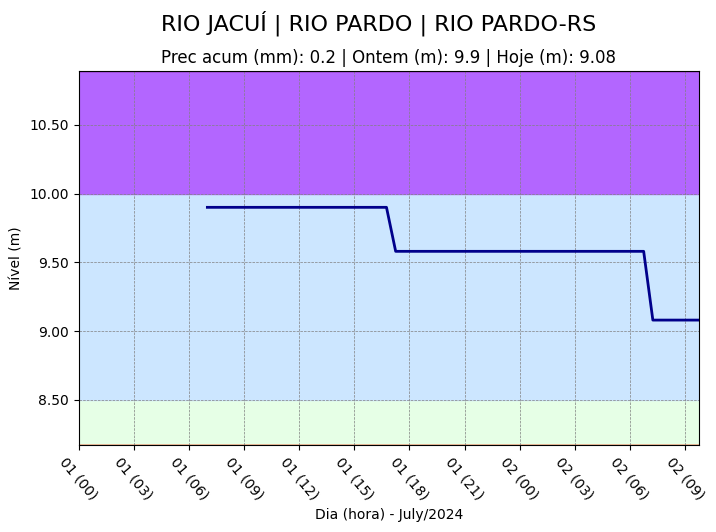

2.9%;CAIS MAUÁ C6;87450004;RIO GUAÍBA;PORTO ALEGRE-RS;sem dados
3.1%;USINA DO GASÔMETRO;87444000;RIO GUAÍBA;PORTO ALEGRE-RS;Chuva:0.0;Nível ontem:3.21;Nível hoje:3.12;ATENÇÃO;ESTÁVEL


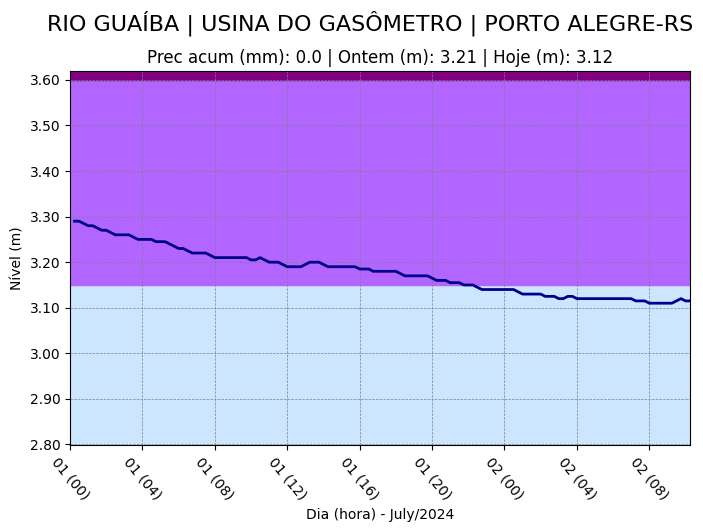

3.2%;UHE ITÁ RIO APUAÊ;72870900;RIO APUAE-MIRIM;MARCELINO RAMOS-RS;Chuva:0.4;Nível ontem:2.23;Nível hoje:2.01;NORMAL;DECLÍNIO


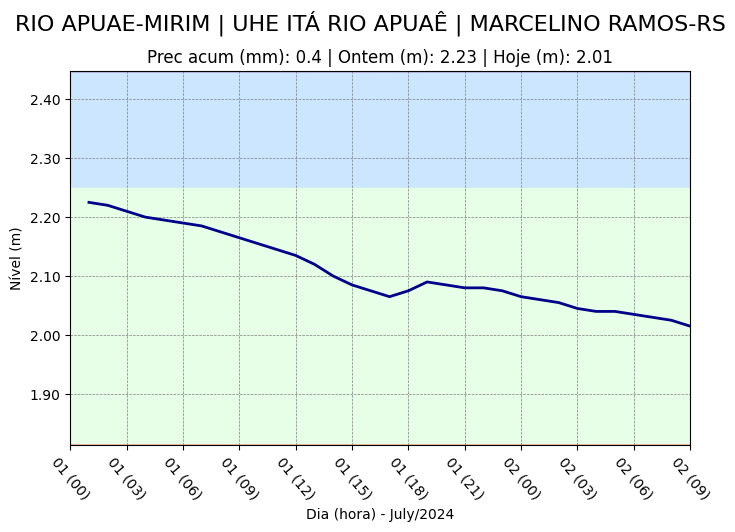

3.4%;SANTO ANGELO;75230000;RIO IJUÍ;ENTRE-IJUIS-RS;Chuva:0.2;Nível ontem:2.53;Nível hoje:2.45;NORMAL;ESTÁVEL


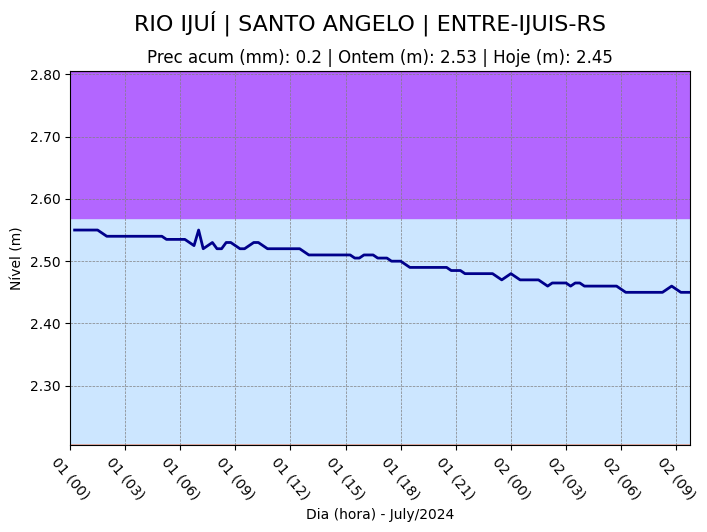

3.5%;ALEGRETE;76750000;RIO IBIRAPUITA;ALEGRETE-RS;Chuva:0.0;Nível ontem:2.11;Nível hoje:1.99;NORMAL;ESTÁVEL


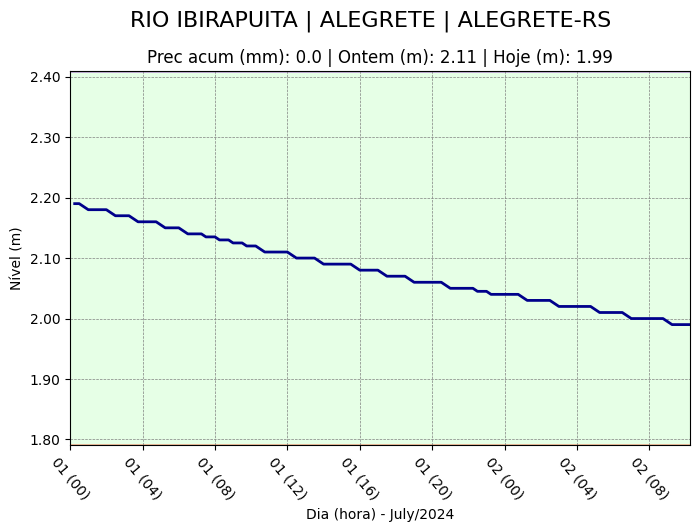

3.7%;ROSÁRIO DO SUL;76310000;RIO SANTA MARIA;ROSÁRIO DO SUL-RS;Chuva:0.2;Nível ontem:0.98;Nível hoje:0.79;NORMAL;ESTÁVEL


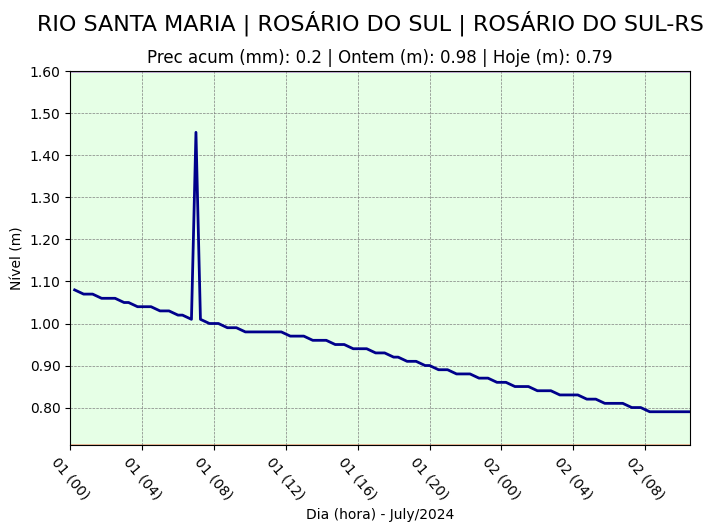

3.8%;MANOEL VIANA;76560000;RIO IBICUÍ;MANOEL VIANA-RS;Chuva:0.0;Nível ontem:6.51;Nível hoje:5.8;NORMAL;DECLÍNIO


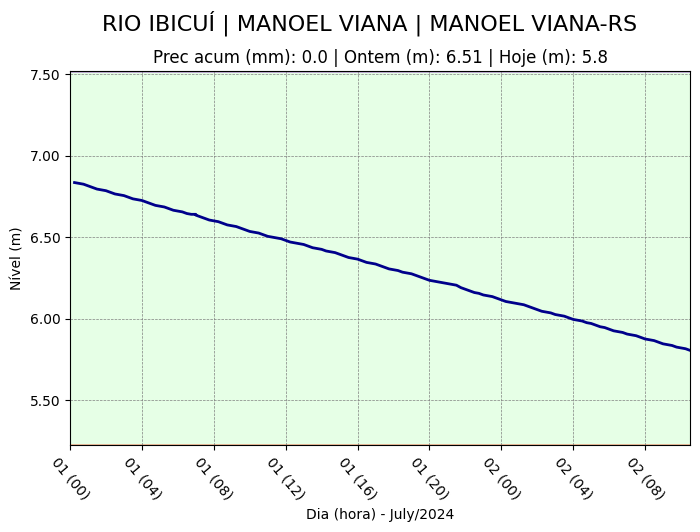

4.0%;IRAÍ;74100000;RIO URUGUAI;IRAÍ-RS;Chuva:0.0;Nível ontem:2.98;Nível hoje:3.11;NORMAL;DECLÍNIO


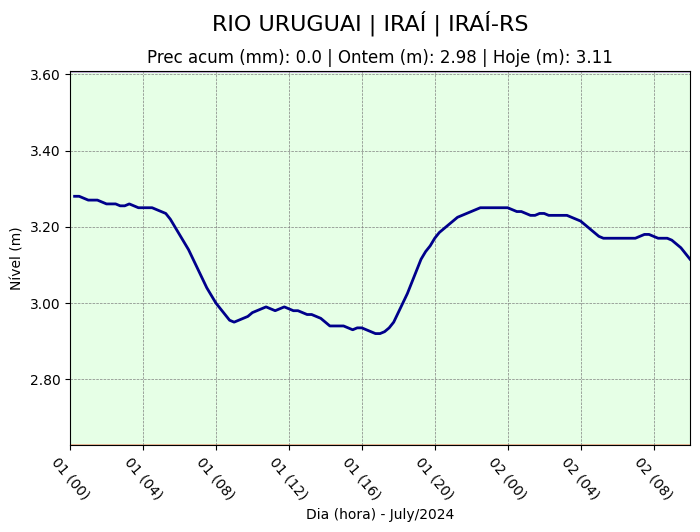

4.1%;ITAPIRANGA;74329000;RIO URUGUAI;ITAPIRANGA-SC;Chuva:0.0;Nível ontem:2.62;Nível hoje:2.52;NORMAL;ESTÁVEL
4.3%;PORTO MAUÁ;74720000;RIO URUGUAI;PORTO MAUA-RS;Chuva:0.0;Nível ontem:4.8;Nível hoje:3.93;NORMAL;DECLÍNIO


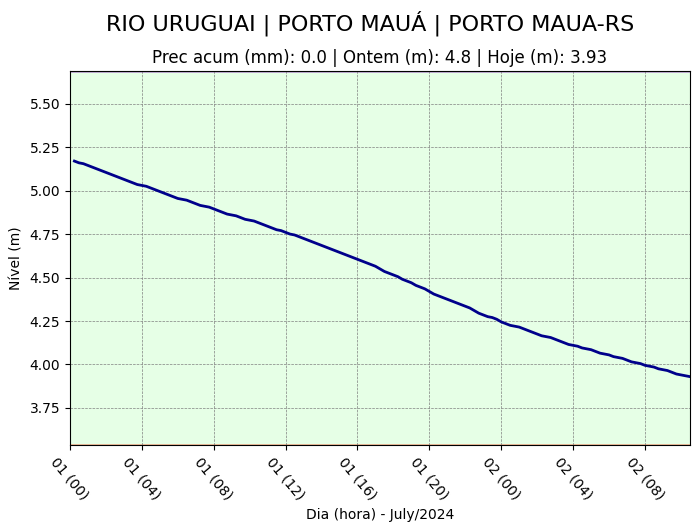

4.5%;PORTO LUCENA;74800000;RIO URUGUAI;PORTO LUCENA-RS;Chuva:0.0;Nível ontem:2.85;Nível hoje:2.25;NORMAL;DECLÍNIO


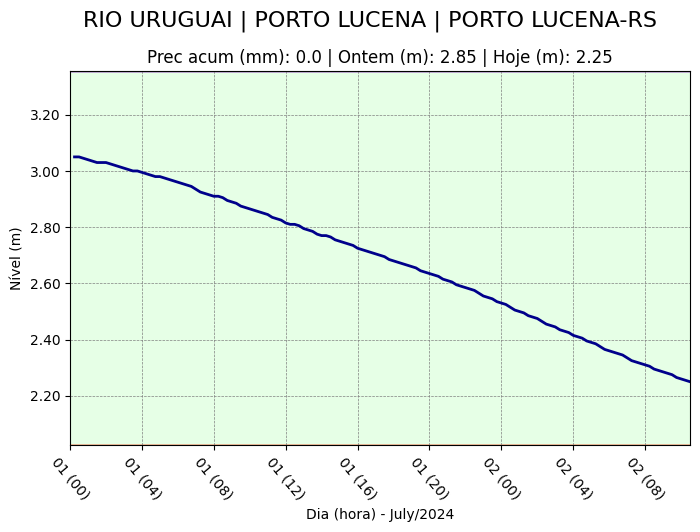

4.6%;GARRUCHOS;75550000;RIO URUGUAI;GARRUCHOS-RS;Chuva:0.2;Nível ontem:5.82;Nível hoje:4.9;NORMAL;DECLÍNIO


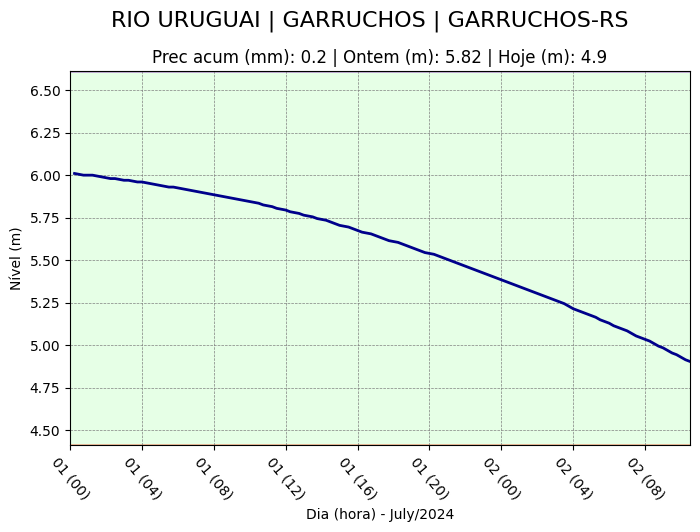

4.8%;PASSO SÃO BORJA;75780000;RIO URUGUAI;SÃO BORJA-RS;Chuva:0.0;Nível ontem:7.21;Nível hoje:6.59;NORMAL;DECLÍNIO


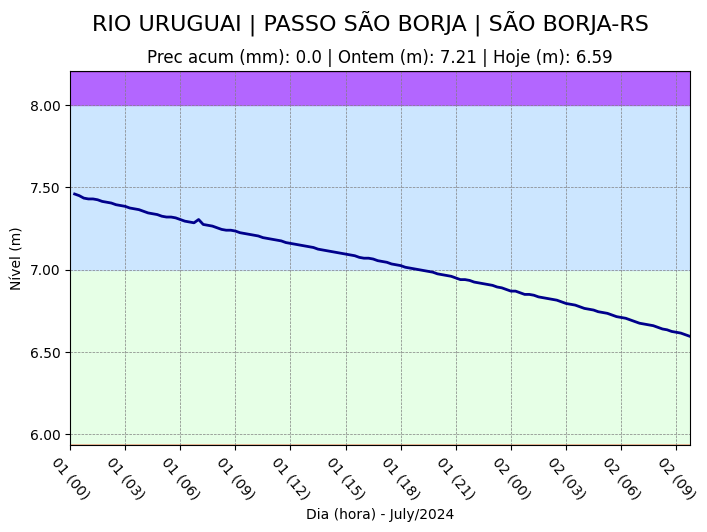

4.9%;ITAQUI;75900000;RIO URUGUAI;ITAQUI-RS;Chuva:0.0;Nível ontem:7.93;Nível hoje:7.54;ALERTA;DECLÍNIO


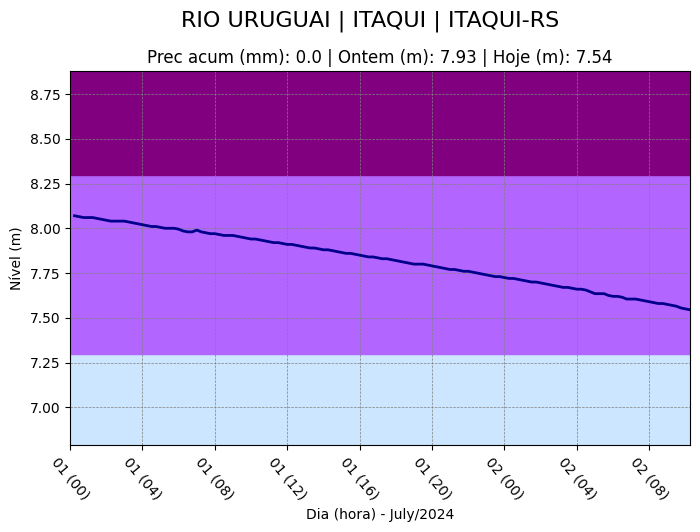

5.1%;URUGUAIANA;77150000;RIO URUGUAI;URUGUAIANA-RS;Chuva:0.0;Nível ontem:8.51;Nível hoje:8.27;ALERTA;DECLÍNIO


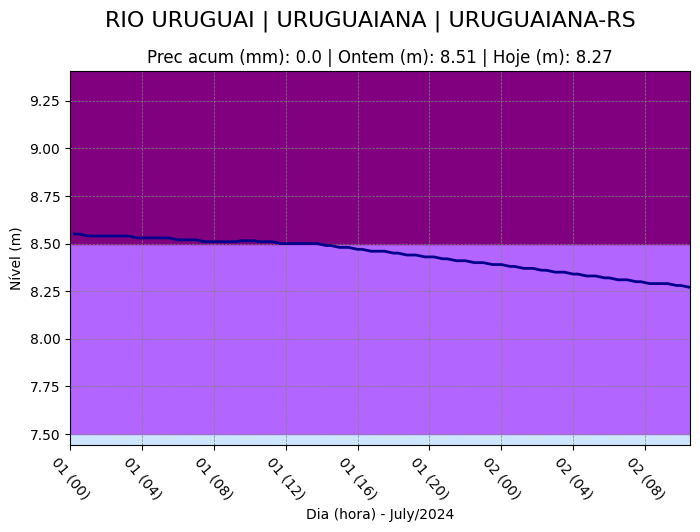

5.2%;QUARAÍ;77500000;RIO QUARAÍ;QUARAÍ-RS;Chuva:0.0;Nível ontem:0.99;Nível hoje:0.94;NORMAL;ESTÁVEL


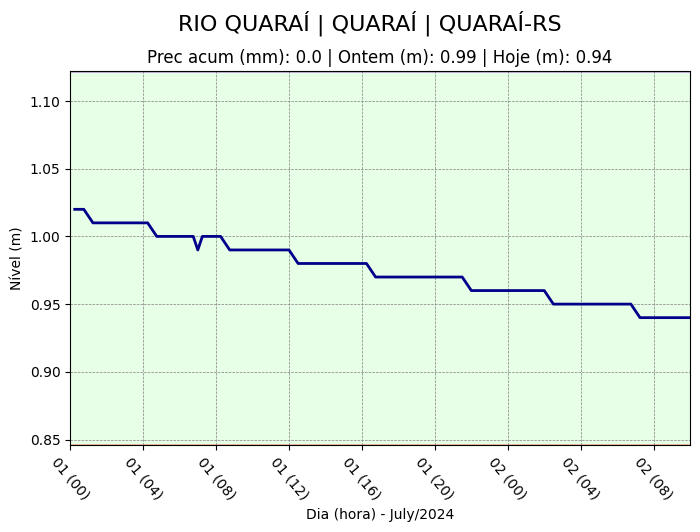

5.4%;ESTÂNCIA DO ESPANTOSO;79400000;RIO NEGRO;BAGÉ-RS;Chuva:0.0;Nível ontem:1.42;Nível hoje:1.36;NORMAL;ESTÁVEL


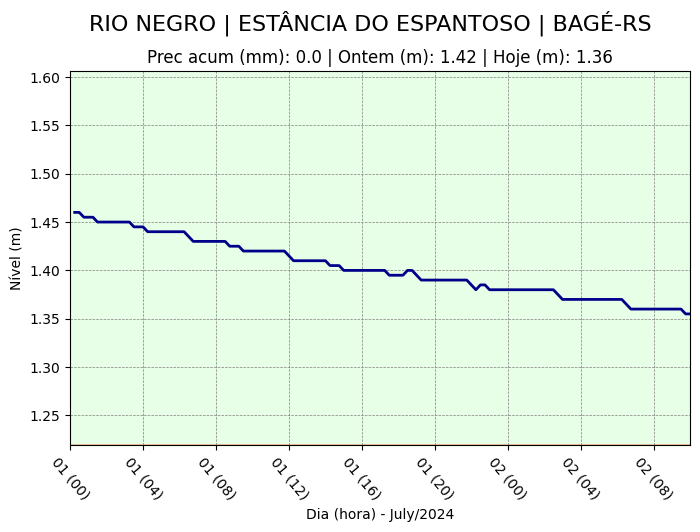

5.5%;PASSO DO MENDONÇA;87905000;RIO CAMAQUÃ;CRISTAL-RS;sem dados
5.7%;PASSO DAS PEDRAS;88260000;RIO JAGUARÃO;JAGUARÃO-RS;Chuva:0.0;Nível ontem:2.36;Nível hoje:2.37;NORMAL;ESTÁVEL


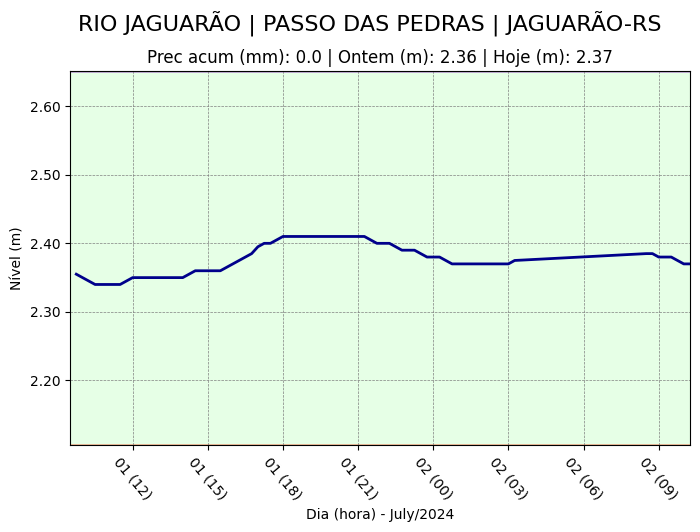

5.8%;PORTO DE PELOTAS;88810100;CANAL DE SÃO GONÇALO;PELOTAS-RS;sem dados
6.0%;FURG-CCMAR;87991100;LAGOA DOS PATOS;RIO GRANDE-RS;sem dados
6.1%;SÃO LOURENÇO;87921000;LAGOA DOS PATOS;SÃO LOURENÇO DO SUL-RS;sem dados
6.3%;LARANJAL;87955000;LAGOA DOS PATOS;PELOTAS-RS;Chuva:0.0;Nível ontem:1.76;Nível hoje:1.79;INUNDAÇÃO;DECLÍNIO


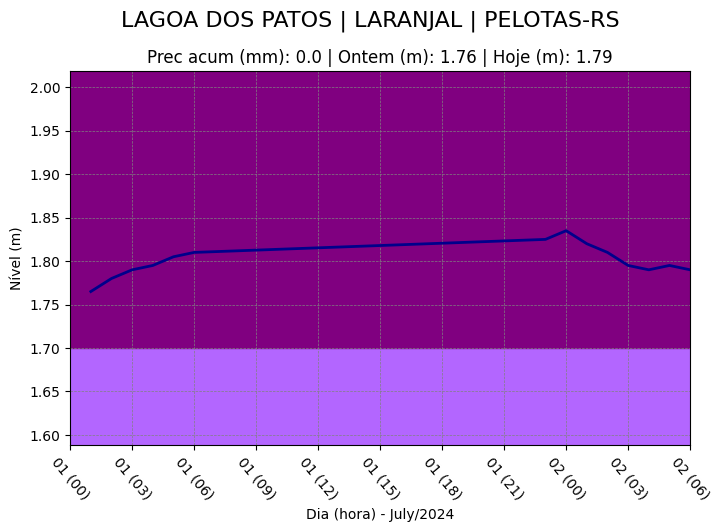

6.5%;RIO GRANDE - REGATAS;87980000;LAGOA DOS PATOS;RIO GRANDE-RS;sem dados
6.6%;COOPERATIVA TRITÍCOLA SANANDUVA;02751063;;SANANDUVA-RS;sem dados
6.8%;PARQUE DE EVENTOS PINHAL DA SERRA;02751066;;PINHAL DA SERRA-RS;sem dados
6.9%;UHE FOZ DO CHAPECÓ NONOAI;02752032;;NONOAI-RS;sem dados
7.1%;UHE ITÁ ERECHIM PLU;02752035;;ERECHIM-RS;sem dados
7.2%;COOPAC CONSTANTINA;02752060;;CONSTANTINA-RS;sem dados
7.4%;AGROP. PAPAGAIO CHARÕA SARANDI;02752061;;SARANDI-RS;sem dados
7.5%;PREFEITURA BARRA DO RIO AZUL;02752062;;BARRA DO RIO AZUL-RS;sem dados
7.7%;PREFEITURA CERRO GRANDE;02753053;;CERRO GRANDE-RS;sem dados
7.8%;CGH LINHA GRANJA VELHA BARRAMENTO;02753058;;TAQUARUÇU DO SUL-RS;sem dados
8.0%;POUSADA APARADOS DA SERRA S.J. AUSENTES;02849066;;SÃO JOSÉ DOS AUSENTES-RS;sem dados
8.1%;VACARIA;02850045;;VACARIA-RS;sem dados
8.3%;BRIGADA MILITAR BOM JESUS;02850048;;BOM JESUS-RS;sem dados
8.4%;GUAPORÉ;02851044;;GUAPORÉ-RS;sem dados
8.6%;UHE MACHADINHO LAGOA VERMELHA;02851061;;LAGOA VERMELHA-RS;sem dados


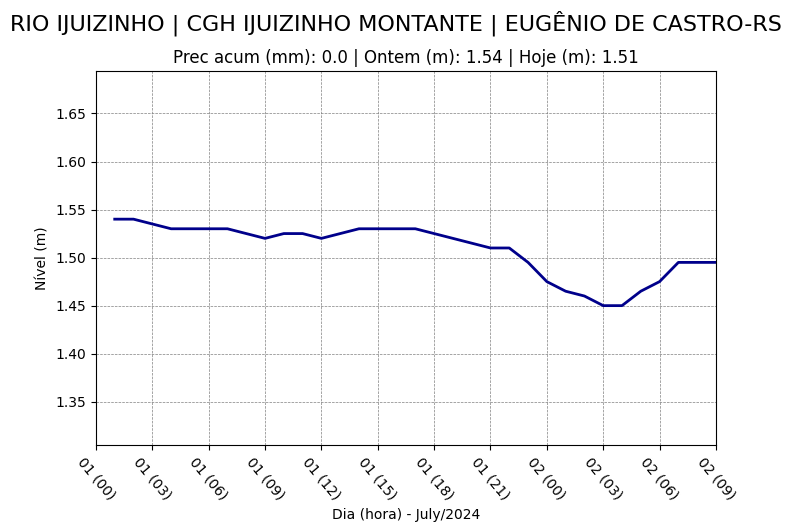

40.9%;CGH IJUIZINHO BARRAMENTO;75288000;RIO IJUIZINHO;ENTRE-IJUIS-RS;Chuva:0.6;Nível ontem:2.35;Nível hoje:2.35;indefinido;ESTÁVEL
41.0%;CGH IJUIZINHO JUSANTE;75288100;RIO IJUIZINHO;ENTRE-IJUIS-RS;Chuva:0.0;Nível ontem:1.09;Nível hoje:1.08;indefinido;ESTÁVEL
41.2%;PCH IJUIZINHO CERMISSÕES MONTANTE;75290000;RIO IJUIZINHO;ENTRE-IJUIS-RS;Chuva:0.2;Nível ontem:1.35;Nível hoje:0.61;NORMAL;DECLÍNIO
41.3%;PCH IJUIZINHO CERMISSÕES BARRAMENTO;75291000;RIO IJUIZINHO;ENTRE-IJUIS-RS;Chuva:0.0;Nível ontem:1.66;Nível hoje:1.44;indefinido;DECLÍNIO
41.5%;UHE SÃO JOSÉ MONTANTE;75305000;RIO IJUÍ;CERRO LARGO-RS;sem dados
41.6%;UHE SÃO JOSÉ ARROIO URUQUA;75307000;ARROIO URUQUA;CAIBATÉ-RS;Chuva:0.2;Nível ontem:1.6;Nível hoje:1.58;NORMAL;ESTÁVEL
41.8%;UHE SÃO JOSÉ RIACHO FUNDO;75318000;RIACHO FUNDO;ROLADOR-RS;Chuva:0.2;Nível ontem:0.61;Nível hoje:0.6;NORMAL;ESTÁVEL
41.9%;UHE SÃO JOSÉ BARRAMENTO;75325000;RIO IJUÍ;SALVADOR DAS MISSÕES-RS;Chuva:0.0;Nível ontem:1.54;Nível hoje:1.54;indefinido;ESTÁVEL
42.1%;UHE 

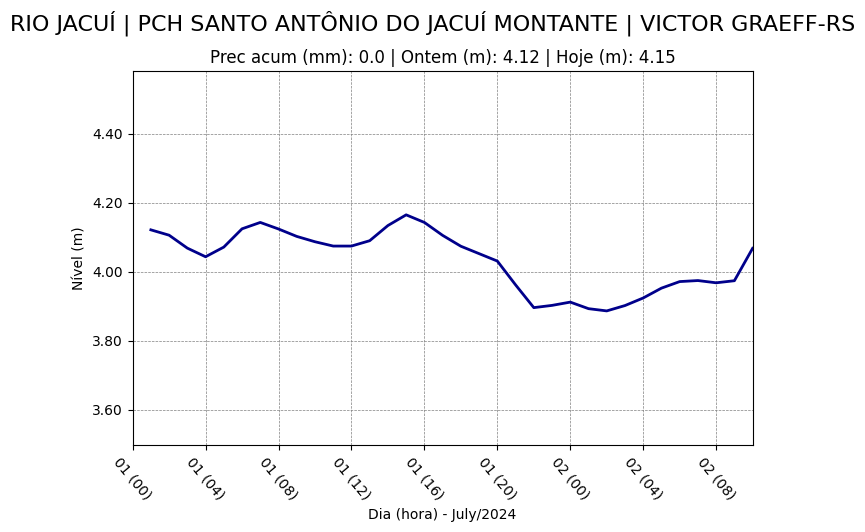

49.5%;PCH COTOVELO DO JACUÍ BARRAMENTO;85074000;RIO JACUÍ;VICTOR GRAEFF-RS;Chuva:0.0;Nível ontem:3.75;Nível hoje:3.75;indefinido;ESTÁVEL
49.6%;PCH COTOVELO DO JACUÍ JUSANTE;85076000;RIO JACUÍ;VICTOR GRAEFF-RS;Chuva:2.4;Nível ontem:2.86;Nível hoje:2.73;indefinido;ELEVAÇÃO


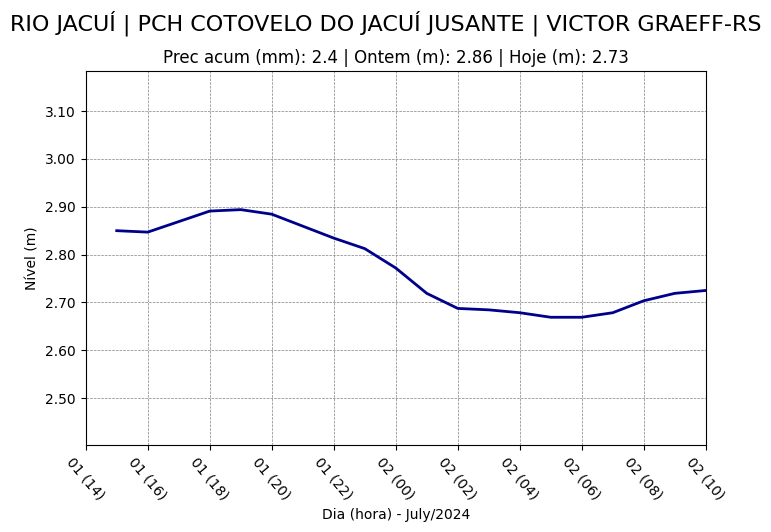

49.8%;UHE PASSO REAL MONTANTE 2;85080001;RIO JACUÍ;ESPUMOSO-RS;Chuva:0.4;Nível ontem:2.18;Nível hoje:2.01;indefinido;DECLÍNIO
49.9%;PISTA DE POUSO ARAMBARÉ;85101000;ARROIO VELHACO;ARAMBARÉ-RS;sem dados
50.1%;CGH COLORADO JUSANTE;85110000;RIO COLORADO;TAPERA-RS;sem dados
50.2%;CGH RP 1 BARRAMENTO;85130000;ARROIO BUTIA;SOLEDADE-RS;Chuva:0.0;Nível ontem:2.22;Nível hoje:2.21;indefinido;ESTÁVEL
50.4%;CGH RP 1 JUSANTE;85130400;ARROIO BUTIA;SOLEDADE-RS;Chuva:0.0;Nível ontem:2.06;Nível hoje:2.01;indefinido;ESTÁVEL
50.5%;UHE PASSO REAL MONTANTE 1;85140000;RIO JACUÍ;ALTO ALEGRE-RS;Chuva:0.0;Nível ontem:5.01;Nível hoje:4.73;indefinido;DECLÍNIO
50.7%;CGH MIRIM BARRAMENTO;85170100;RIO JACUÍ-MIRIM;CARAZINHO-RS;sem dados
50.8%;CGH MIRIM JUSANTE;85170150;RIO JACUÍ-MIRIM;CARAZINHO-RS;Chuva:0.0;Nível ontem:1.34;Nível hoje:1.32;indefinido;ESTÁVEL
51.0%;UHE PASSO REAL RIO JACUÍ-MIRIM;85180000;RIO JACUÍ-MIRIM;IBIRUBA-RS;Chuva:0.2;Nível ontem:1.99;Nível hoje:1.9;indefinido;DECLÍNIO
51.2%;ARROIO BARRIGA;8520

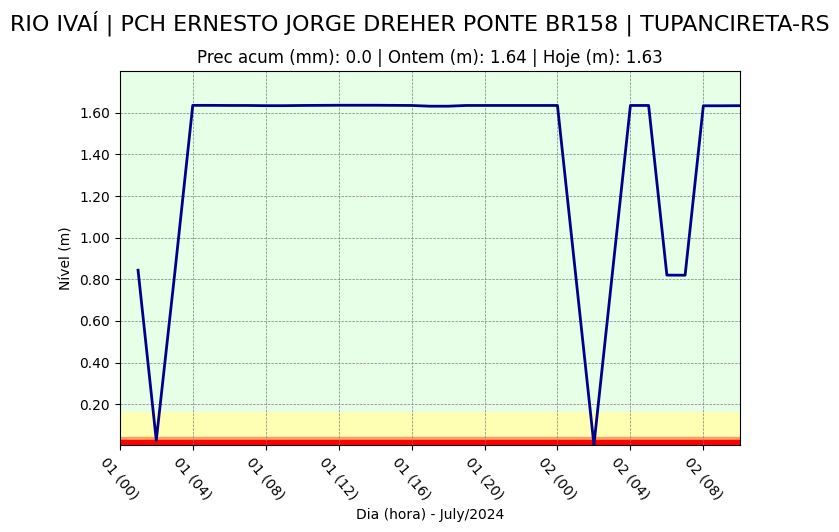

52.2%;PCH ERNESTO JORGE DREHER PONTE RINCÃO DO IVAI;85309000;RIO IVAÍ;JÚLIO DE CASTILHOS-RS;sem dados
52.4%;PCH ERNESTO JORGE DREHER MONTANTE 1;85310000;RIO IVAÍ;SALTO DO JACUÍ-RS;sem dados
52.5%;PCH ERNESTO JORGE DREHER  BARRAMENTO;85311000;RIO IVAÍ;SALTO DO JACUÍ-RS;Chuva:0.0;Nível ontem:2.82;Nível hoje:2.82;indefinido;ESTÁVEL
52.7%;PCH ENGENHEIRO HENRIQUE KOTZIAN BARRAMENTO;85349000;RIO IVAÍ;JÚLIO DE CASTILHOS-RS;sem dados
52.8%;PCH ENGENHEIRO HENRIQUE KOTZIAN JUSANTE;85350000;RIO IVAÍ;JÚLIO DE CASTILHOS-RS;sem dados
53.0%;UHE ITAÚBA ARROIO DA RESERVA;85360050;ARROIO DA RESERVA;PINHAL GRANDE-RS;sem dados
53.1%;UHE ITAÚBA ARROIO DO TIGRE;85360100;ARROIO DO ;PINHAL GRANDE-RS;sem dados
53.3%;UHE ITAÚBA BARRAMENTO;85365000;RIO JACUÍ;PINHAL GRANDE-RS;Chuva:0.0;Nível ontem:1.84;Nível hoje:1.84;indefinido;ESTÁVEL
53.5%;UHE ITAÚBA ARROIO POVINHO;85365500;ARROIO POV;NICOLAU VERGUEIRO-RS;Chuva:0.0;Nível ontem:1.76;Nível hoje:1.7;indefinido;ESTÁVEL
53.6%;UHE DONA FRANCISCA RIO JACUIZINHO;85380

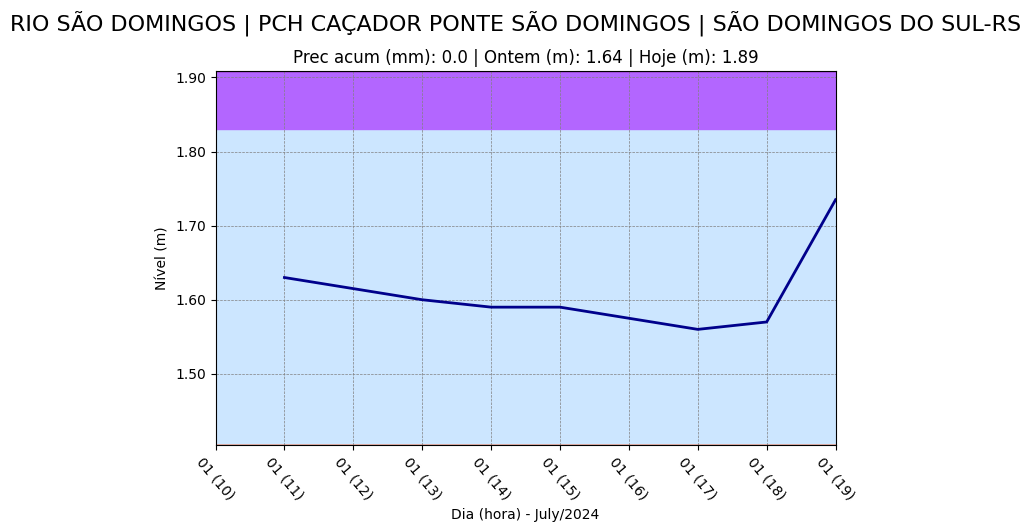

65.4%;PCH CAÇADOR MONTANTE;86488000;RIO CARREIRO;SERAFINA CORRÊA-RS;Chuva:0.0;Nível ontem:2.06;Nível hoje:2.29;NORMAL;ELEVAÇÃO


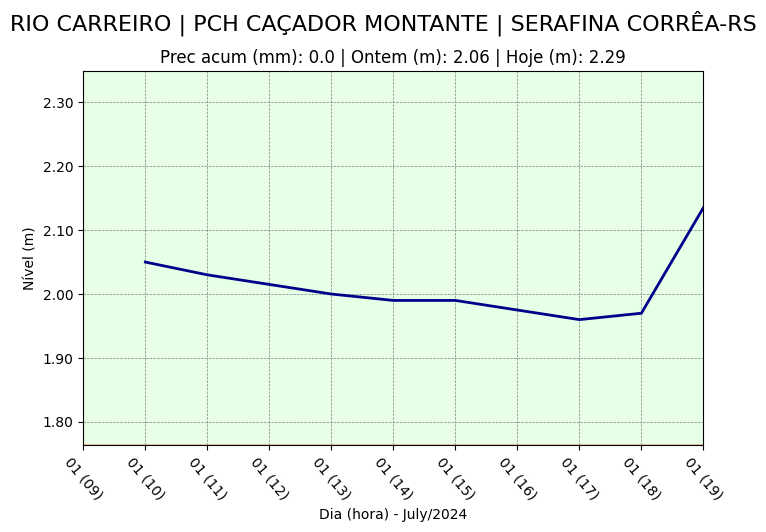

65.6%;PCH CAÇADOR BARRAMENTO;86489000;RIO CARREIRO;SERAFINA CORRÊA-RS;Chuva:0.0;Nível ontem:4.26;Nível hoje:4.26;indefinido;ESTÁVEL
65.7%;PCH BOA FÉ MONTANTE;86490500;RIO CARREIRO;SERAFINA CORRÊA-RS;Chuva:0.4;Nível ontem:3.05;Nível hoje:3.05;indefinido;ESTÁVEL
65.9%;PCH BOA FÉ BARRAMENTO;86493000;RIO CARREIRO;NOVA BASSANO-RS;sem dados
66.1%;PCH BOA FÉ ALÇA;86494000;RIO CARREIRO;SERAFINA CORRÊA-RS;Chuva:0.0;Nível ontem:3.48;Nível hoje:3.48;indefinido;ESTÁVEL
66.2%;PCH SÃO PAULO BARRAMENTO;86495500;RIO CARREIRO;GUAPORÉ-RS;Chuva:0.0;Nível ontem:3.29;Nível hoje:3.29;indefinido;ESTÁVEL
66.4%;PCH SÃO PAULO ALÇA;86496000;RIO CARREIRO;VISTA ALEGRE DO PRATA-RS;Chuva:0.0;Nível ontem:0.58;Nível hoje:0.42;indefinido;RÁPIDA ELEVAÇÃO


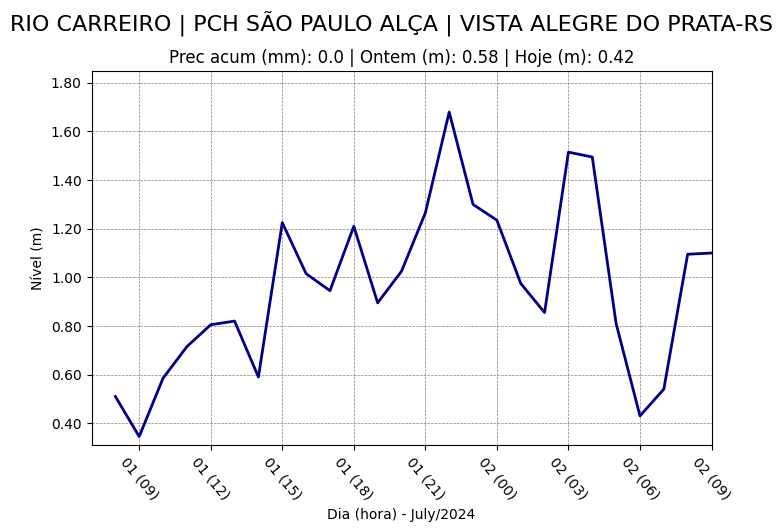

66.5%;PCH SÃO PAULO JUSANTE;86497000;RIO CARREIRO;VISTA ALEGRE DO PRATA-RS;Chuva:0.0;Nível ontem:3.81;Nível hoje:3.81;indefinido;ESTÁVEL
66.7%;PCH AUTÓDROMO BARRAMENTO;86497400;RIO CARREIRO;GUAPORÉ-RS;Chuva:0.0;Nível ontem:2.8;Nível hoje:2.79;indefinido;ESTÁVEL
66.8%;PCH AUTÓDROMO ALÇA;86497500;RIO CARREIRO;GUAPORÉ-RS;Chuva:0.0;Nível ontem:1.43;Nível hoje:1.43;indefinido;ESTÁVEL
67.0%;PCH AUTÓDROMO JUSANTE;86498000;RIO CARREIRO;GUAPORÉ-RS;sem dados
67.1%;PCH LINHA EMILIA BARRAMENTO;86505400;RIO CARREIRO;DOIS LAJEADOS-RS;Chuva:0.0;Nível ontem:0.0;Nível hoje:0.0;indefinido;ESTÁVEL
67.3%;PCH LINHA EMILIA JUSANTE;86505500;RIO CARREIRO;DOIS LAJEADOS-RS;Chuva:0.0;Nível ontem:0.9;Nível hoje:0.9;indefinido;ESTÁVEL
67.4%;PCH COTIPORÃ BARRAMENTO;86506000;RIO CARREIRO;COTIPORÃ-RS;Chuva:0.0;Nível ontem:0.0;Nível hoje:0.0;indefinido;ESTÁVEL
67.6%;PCH COTIPORÃ JUSANTE;86507000;RIO CARREIRO;COTIPORÃ-RS;Chuva:0.0;Nível ontem:-2.4;Nível hoje:-2.4;indefinido;ESTÁVEL
67.7%;CGH CAPIGUI BARRAMENTO;86520000

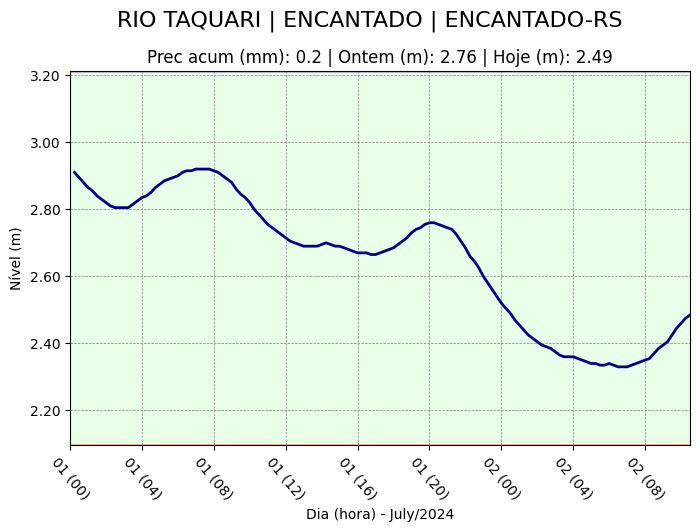

68.4%;PCH RASTRO DE AUTO MONTANTE;86743700;RIO FORQUETA;SÃO JOSÉ DO HERVAL-RS;sem dados
68.5%;PCH RASTRO DE AUTO BARRAMENTO;86743800;RIO FORQUETA;SÃO JOSÉ DO HERVAL-RS;Chuva:0.0;Nível ontem:2.5;Nível hoje:2.5;indefinido;ESTÁVEL
68.7%;PCH SALTO FORQUETA BARRAMENTO;86743900;RIO FORQUETA;PUTINGA-RS;sem dados
68.8%;PCH SALTO FORQUETA ALÇA;86743950;RIO FORQUETA;PUTINGA-RS;sem dados
69.0%;PCH SALTO FORQUETA JUSANTE;86744000;RIO FORQUETA;PUTINGA-RS;sem dados
69.1%;PONTE RIO FORQUETINHA;86746900;ARROIO FORQUETINHA;FORQUETINHA-RS;sem dados
69.3%;CGH SOLEDADE BARRAMENTO;86748001;RIO FÃO;FONTOURA XAVIER-RS;sem dados
69.4%;BARRA DO FÃO;86780000;RIO FORQUETA;TRAVESSEIRO-RS;sem dados
69.6%;PORTO MARIANTE;86895000;RIO TAQUARI;VENANCIO AIRES-RS;Chuva:0.0;Nível ontem:5.82;Nível hoje:5.82;NORMAL;ESTÁVEL
69.7%;TRIUNFO;87010000;RIO JACUÍ;TRIUNFO-RS;sem dados
69.9%;SÃO JERÔNIMO;87020000;RIO JACUÍ;SÃO JERÔNIMO-RS;sem dados
70.0%;UHE BUGRES DIVISA MONTANTE;87068000;ARROIO DO ;SÃO FRANCISCO DE PAULA-RS;Chuva:

<ipython-input-14-73d35e093261>:258: RuntimeWarning: All-NaN axis encountered
  mA = np.nanmax(df['Nivel (m)'])
<ipython-input-14-73d35e093261>:260: RuntimeWarning: All-NaN axis encountered
  mI = np.nanmin(df['Nivel (m)'])


79.1%;PEDRO OSÓRIO;88641000;RIO PIRATINI;PEDRO OSÓRIO-RS;Chuva:0.0;Nível ontem:2.86;Nível hoje:2.86;NORMAL;inconclusivo
79.3%;ECLUSA SÃO GONÇALO;88690050;CANAL DE SÃO GONÇALO;CAPÃO DO LEÃO-RS;sem dados
79.4%;SANTA ISABEL CGH (UFPEL);88700010;CANAL DE SÃO GONÇALO;ARROIO GRANDE-RS;sem dados
79.6%;SAN JAVIER (DNCPVN-564);74830000;RIO URUGUAI;ARGENTINA-AR;sem dados
79.7%;CGH BELMONTE BARRAMENTO;74423080;RIO DAS FLORES;BANDEIRANTE-SC;sem dados
79.9%;PCH SALTO DAS FLORES BARRAMENTO;74400080;RIO DAS FLORES;PARAÍSO-SC;Chuva:0.0;Nível ontem:4.4;Nível hoje:4.4;indefinido;ESTÁVEL
80.0%;PCH SALTO DAS FLORES MONTANTE;74400000;RIO DAS FLORES;PARAÍSO-SC;Chuva:0.0;Nível ontem:1.42;Nível hoje:1.36;indefinido;ESTÁVEL
80.2%;PCH FLOR DO SERTÃO JUSANTE;74324000;RIO DAS ANTAS;FLOR DO SERTÃO-SC;sem dados
80.3%;PCH FLOR DO SERTÃO BARRAMENTO;74323000;RIO DAS ANTAS;FLOR DO SERTÃO-SC;Chuva:0.0;Nível ontem:2.54;Nível hoje:2.53;indefinido;ESTÁVEL
80.5%;PCH FLOR DO SERTÃO LINHA AZUL;74322000;RIO SARGENTO;ROMELÂNDIA

In [14]:
c = 0
pd.Series(dtype='float64')

for station in stations:

    c = c+1

    perc = round((c/len(stations))*100, 1)

    url=f'http://telemetriaws1.ana.gov.br/ServiceANA.asmx/DadosHidrometeorologicos?CodEstacao={station}&DataInicio={dataInicio}&DataFim={dataFim}'
    response = requests.get(url)
    Bs_data = BeautifulSoup(response.text, "xml")

    df = pd.DataFrame()

    matchs = inventario_DATAFRAME[inventario_DATAFRAME['Codigos'] == str(station)]
    nome_estacao = str(matchs.iloc[0]['Nomes'])
    nome_estacao = nome_estacao.replace('/','-')

    nome_rio = str(matchs.iloc[0]['NomeRio'])
    nome_rio = nome_rio.replace('/','-')

    nome_muni = str(matchs.iloc[0]['Municipio'])
    nome_muni = nome_muni.replace('/','-')

# Verifica se os valores não estão ausentes antes de tentar a conversão
    Lat_str = matchs.iloc[0]['Lat']
    Lon_str = matchs.iloc[0]['Lon']

    if pd.notna(Lat_str) and pd.notna(Lon_str):
# Converta apenas se os valores não estiverem ausentes
        Lat = float(Lat_str)
        Lon = float(Lon_str)
    else:
# Atribua NaN se algum dos valores estiver ausente
        Lat = np.NaN
        Lon = np.NaN


    index_estacao = cotas[cotas['Codigo'] == int(station)]

    if len(index_estacao) > 0:

      index_estacao = index_estacao.iloc[0]

      cota_inunda = index_estacao['Cota Inundação']
      cota_alerta = index_estacao['Cota Alerta']
      cota_atencao = index_estacao['Cota Atenção']
      cota_1 = index_estacao['N1']
      cota_5 = index_estacao['N5']
      cota_10 = index_estacao['N10']
      cota_50 = index_estacao['N50']
      cota_75 = index_estacao['N75']
      cota_85 = index_estacao['N85']
      cota_90 = index_estacao['N90']
      cota_95 = index_estacao['N95']


      if index_estacao['Cota Inundação'] == '-':
        cota_inunda = np.NaN
      if index_estacao['Cota Alerta'] == '-':
        cota_alerta = np.NaN
      if index_estacao['Cota Atenção'] == '-':
        cota_atencao = np.NaN
      if index_estacao['N50'] == '-':
        cota_50 = np.NaN
      if index_estacao['N75'] == '-':
        cota_75 = np.NaN
      if index_estacao['N85'] == '-':
        cota_85 = np.NaN
      if index_estacao['N90'] == '-':
        cota_90 = np.NaN
      if index_estacao['N95'] == '-':
        cota_95 = np.NaN
      if index_estacao['N10'] == '-':
        cota_10 = np.NaN
      if index_estacao['N5'] == '-':
        cota_5 = np.NaN
      if index_estacao['N1'] == '-':
        cota_1 = np.NaN

    else:
      cota_inunda = np.NaN
      cota_alerta = np.NaN
      cota_atencao = np.NaN
      cota_1 = np.NaN
      cota_5 = np.NaN
      cota_10 = np.NaN
      cota_50 = np.NaN
      cota_75 = np.NaN
      cota_85 = np.NaN
      cota_90 = np.NaN
      cota_95 = np.NaN

    datas = Bs_data.findAll('DataHora')
    datas = [i.text for i in datas]
    df['Data/Hora'] = pd.Series(datas)
    df['Data/Hora'] = pd.to_datetime(df['Data/Hora'])

    nivel = Bs_data.findAll('Nivel')
    nivel = [i.text for i in nivel]
    df['Nivel (cm)'] = pd.Series(nivel, dtype='string')
    df['Nivel (cm)'] = pd.to_numeric(df['Nivel (cm)'])

    chuva = Bs_data.findAll('Chuva')
    chuva = [i.text for i in chuva]
    df['Chuva'] = pd.Series(chuva, dtype='string')
    df['Chuva'] = pd.to_numeric(df['Chuva'], errors='coerce')
    # df['Chuva'].fillna(0, inplace=True)

    df = df.set_index(df['Data/Hora']).sort_index()
    df = df.drop(columns=['Data/Hora'])
    # df = df.resample('H').mean()


    verifica_nivel = mean(df['Nivel (cm)'])
    if pd.notna(verifica_nivel) and verifica_nivel > 5000:
      df['Nivel (m)'] = round(pd.to_numeric(df['Nivel (cm)'])/10000,3)
    else:
      df['Nivel (m)'] = round(pd.to_numeric(df['Nivel (cm)'])/100,3)



    serie_notna = df['Nivel (m)'].dropna()
    if len(serie_notna) < 1:
      print(f'{perc}%;{nome_estacao};{station};{nome_rio};{nome_muni};sem dados')
      continue
    elif len(serie_notna) >= 96:
        last = round(serie_notna.iloc[-1],2)
        first = round(serie_notna.iloc[-96],2)
    elif not serie_notna.empty:
        last = round(serie_notna.iloc[-1],2)
        first = round(serie_notna.iloc[0],2)
    else:
        last = np.NaN
        first = np.NaN

    df['Nivel (m)'] = df['Nivel (m)'].interpolate(method='pad')
    df['Nivel (m)'] = df['Nivel (m)'].rolling(2).median()


    ### Status

    Status = 'indefinido'
    Status_cor = 'silver'

    if last >= (cota_atencao/100):
      Status = 'ATENÇÃO'
      Status_cor = 'cornflowerblue'

      if last >= (cota_alerta/100):
        Status = 'ALERTA'
        Status_cor = 'mediumpurple'

        if last >= (cota_inunda/100):
          Status = 'INUNDAÇÃO'
          Status_cor = 'purple'

    elif last >= (cota_85/100):
      Status = 'NORMAL'
      Status_cor = 'limegreen'

      if last >= (cota_atencao/100):
        Status = 'ATENÇÃO'
        Status_cor = 'cornflowerblue'

        if last >= (cota_10/100):
          Status = 'ATENÇÃO'
          Status_cor = 'cornflowerblue'

          if last >= (cota_alerta/100):
            Status = 'ALERTA'
            Status_cor = 'mediumpurple'

            if last >= (cota_5/100):
              Status = 'ALERTA'
              Status_cor = 'mediumpurple'

              if last >= (cota_inunda/100):
                Status = 'INUNDAÇÃO'
                Status_cor = 'purple'

                if last >= (cota_1/100):
                  Status = 'INUNDAÇÃO'
                  Status_cor = 'purple'


    elif last < (cota_atencao/100):
      Status = 'NORMAL'
      Status_cor = 'limegreen'

      if last < (cota_10/100):
        Status = 'NORMAL'
        Status_cor = 'limegreen'

        if last < (cota_85/100):
          Status = 'Atenção estiagem'
          Status_cor ='gold'

          if last < (cota_90/100):
            Status = 'Alerta estiagem'
            Status_cor = 'darkorange'

            if last < (cota_95/100):
              Status = 'Estiagem'
              Status_cor = 'red'

    else:
      Status = 'indefinido'
      Status_cor = 'silver'



    ### Tendencia

    yy = df['Nivel (m)'].tail(5)
    yy = yy.dropna()

    if len(yy) >= 3:

      yy = list(yy)

      xx = np.array(range(len(yy)))
      xx = xx.reshape((-1, 1))

      model = LinearRegression()
      model = LinearRegression().fit(xx, yy)

      r_sq = model.score(xx, yy)
      coef_ang = model.coef_# COEFICIENTE ANGULAR

      if coef_ang[0] >= -0.00300 and coef_ang[0] <= 0.00500:
        Tendencia_cor = 'lightgreen'
        Tendencia = 'ESTÁVEL'

      elif coef_ang[0] > 0.00500 and coef_ang[0] <= 0.07000:
        Tendencia_cor = 'magenta'
        Tendencia = 'ELEVAÇÃO'

      elif coef_ang[0] > 0.07000 and coef_ang[0] < 1.0000:
        Tendencia_cor = 'black'
        Tendencia = 'RÁPIDA ELEVAÇÃO'

      elif coef_ang[0] < -0.00300:
        Tendencia_cor = 'gold'
        Tendencia = 'DECLÍNIO'

      else:
        Tendencia_cor = 'silver'
        Tendencia = 'inconclusivo'

    else:
      Tendencia_cor = 'silver'
      Tendencia = 'inconclusivo'

    #######################################################

    mA = np.nanmax(df['Nivel (m)'])

    mI = np.nanmin(df['Nivel (m)'])

    prec_ac = df['Chuva'].sum()

    prec_ac = round(prec_ac,1)


    linha = pd.DataFrame([[nome_rio, int(station), nome_estacao, Lat, Lon, prec_ac, first, last, Tendencia, Tendencia_cor, coef_ang[0], Status, Status_cor]],
                          columns=['Rio', 'Codigo', 'Nome',
                                  'Lat', 'Lon' , 'Precipitação acumulada 24h (mm)', 'Nível ontem',
                                  'Nível atual (m)', 'Tendencia', 'Tendencia_cor', 'Coeficiente angular',
                                  'Status', 'Status_cor'])

    planilha = pd.concat([linha, planilha], ignore_index=True)


    ##################### PRINTA DADOS DA ESTAÇÃO #####################


    if Status == 'ALERTA' or Status == 'ATENÇÃO' or Status == 'INUNDAÇÃO' or Tendencia =='ELEVAÇÃO' or Tendencia =='RÁPIDA ELEVAÇÃO':
      print(f'{perc}%;{nome_estacao};{station};{nome_rio};{nome_muni};Chuva:{prec_ac};Nível ontem:{first};Nível hoje:{last};{Status};{Tendencia}')

    else:
      print(f'{perc}%;{nome_estacao};{station};{nome_rio};{nome_muni};Chuva:{prec_ac};Nível ontem:{first};Nível hoje:{last};{Status};{Tendencia}')


    ################### PLOTANDO ####################

    if c <= len(stations_monitora) or Tendencia =='ELEVAÇÃO' or Tendencia =='RÁPIDA ELEVAÇÃO' or Status == 'ATENÇÃO' or Status == 'ALERTA' or Status == 'INUNDAÇÃO':
     if nome_muni.endswith('RS'):

      fig = plt.figure()
      fig.set_figheight(5)
      fig.set_figwidth(8)

      spec = gridspec.GridSpec(ncols=1, nrows=2, hspace=0.01, height_ratios=[0.1, 4])

      # # CHUVA

      # fig.tight_layout()
      fig.suptitle(nome_rio + ' | ' + nome_estacao + ' | ' + nome_muni , fontsize = 16)

      df.index = pd.to_datetime(df.index)

      ## NIVEIS

      if mA<0:
        LI = mI
        LP = mA
      elif mI>50:
        LI = mI-0.35
        LP = mA+0.35
      else:
        LI = 0.9*mI
        LP = 1.10*mA

      ax1 = fig.add_subplot(spec[1])

      if np.isnan(cota_10)==False:
        ax1.fill_between(df.index, cota_10/100, cota_5/100, color = (0.8,0.9,1,1)) #atencao inunda

      if np.isnan(cota_5)==False:
        ax1.fill_between(df.index, cota_5/100, cota_1/100, color = (0.7,0.4,1,1))  # alerta inunda

      if np.isnan(cota_1)==False:
        ax1.fill_between(df.index, cota_1/100, LP, color = 'purple')  # inundacao

      if np.isnan(cota_10)==False:
        ax1.fill_between(df.index, cota_85/100, cota_10/100, color = (0.9,1,0.9,1)) #seguro

      if np.isnan(cota_10)==False:
        ax1.fill_between(df.index, cota_85/100, cota_atencao/100, color = (0.9,1,0.9,1)) #seguro

      if np.isnan(cota_atencao)==False:
        ax1.fill_between(df.index, LI, cota_atencao/100, color = (0.9,1,0.9,1)) #seguro

      if np.isnan(cota_85)==False:
        ax1.fill_between(df.index, LI, cota_85/100, color = (1,1,0.7,1)) # amarelinho

      if np.isnan(cota_90)==False:
        ax1.fill_between(df.index, LI, cota_90/100, color = 'sandybrown')

      if np.isnan(cota_95)==False:
        ax1.fill_between(df.index, LI, cota_95/100, color = 'red')

      if np.isnan(cota_atencao)==False:
        ax1.fill_between(df.index, cota_atencao/100, LP, color = (0.8,0.9,1,1)) # atencao inunda

      if np.isnan(cota_alerta)==False:
        ax1.fill_between(df.index, cota_alerta/100, LP, color =  (0.7,0.4,1,1))  # alerta inunda

      if np.isnan(cota_inunda)==False:
        ax1.fill_between(df.index, cota_inunda/100, LP, color = 'purple')  # inundacao


      ax1.set_title('Prec acum (mm): ' + str(prec_ac) + ' | Ontem (m): ' + str(first) + ' | Hoje (m): ' + str(last), fontsize = 12)

      ax1.plot(df.index, df['Nivel (m)'], color='Darkblue', linewidth = 2.0, alpha = 1)

      ax1.set_ylabel('Nível (m)',color='k', fontsize = 10)
      ax1.set_xlabel('Dia (hora) - ' + datetime.now().strftime("%B/%Y"), color='k', fontsize = 10)
      ax1.set_xlim(df.index[0], df.index[-1])
      ax1.set_ylim(LI, LP)
      ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      myFmt = mdates.DateFormatter('%d (%H)')
      ax1.xaxis.set_major_formatter(myFmt)
      ax1.grid(axis = 'y', color = 'Grey', linestyle = '--', linewidth = 0.5)
      ax1.grid(axis = 'x', color = 'Grey', linestyle = '--', linewidth = 0.5)
      plt.xticks(rotation=-50)
      plt.show()
      plt.close()

In [15]:
planilha_monitoramento = pd.DataFrame(columns=['Rio', 'Codigo', 'Nome',
                                          'Lat', 'Lon', 'Precipitação acumulada 24h (mm)',
                                          'Nível ontem', 'Nível atual (m)', 'Tendencia',
                                          'Tendencia_cor', 'Coeficiente angular',
                                          'Status', 'Status_cor'])

for station in stations_monitora:

  index_estacao = planilha[planilha['Codigo'] == station]

  if index_estacao.empty:
    vazia = pd.DataFrame([[np.nan, station, np.nan, np.nan, np.nan, np.nan,
                           np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                           np.nan]], columns=['Rio', 'Codigo', 'Nome',
                                          'Lat', 'Lon', 'Precipitação acumulada 24h (mm)',
                                          'Nível ontem', 'Nível atual (m)', 'Tendencia',
                                          'Tendencia_cor', 'Coeficiente angular',
                                          'Status', 'Status_cor'])


    planilha_monitoramento = pd.concat([planilha_monitoramento,vazia], ignore_index=True)

  else:
    planilha_monitoramento = pd.concat([planilha_monitoramento,index_estacao], ignore_index=True)

# Excluindo coluna
planilha_monitoramento = planilha_monitoramento.drop(columns=['Tendencia_cor', 'Coeficiente angular', 'Status_cor'])

filename = (f'Monitoramento.xlsx')
planilha_monitoramento.to_excel(f'{diretorio}{filename}', index=False) #, encoding = 'utf-8-sig')


In [16]:
df_rap_elevacao=planilha.query("Tendencia in ('RÁPIDA ELEVAÇÃO')").reset_index()
df_elevacao=planilha.query("Tendencia in ('ELEVAÇÃO')").reset_index()
df_estavel=planilha.query("Tendencia in ('ESTÁVEL')").reset_index()
df_declinio=planilha.query("Tendencia in ('DECLÍNIO')").reset_index()
df_inconclusivo=planilha.query("Tendencia in ('inconclusivo')").reset_index()

In [17]:
#Filtros para bater tendencias e condições

com_limiar = planilha[~planilha['Status_cor'].isin(['silver'])]

# Filtrando df_rap_elevacao com base em com_limiar
df_rap_elevacao2 = df_rap_elevacao.merge(com_limiar, on='Codigo', how='inner')

# Filtrando df_elevacao com base em com_limiar
df_elevacao2 = df_elevacao.merge(com_limiar, on='Codigo', how='inner')

# Filtrando df_estavel com base em com_limiar
df_estavel2 = df_estavel.merge(com_limiar, on='Codigo', how='inner')

# Filtrando df_declinio com base em com_limiar
df_declinio2 = df_declinio.merge(com_limiar, on='Codigo', how='inner')

# Filtrando df_inconclusivo com base em com_limiar
df_inconclusivo2 = df_inconclusivo.merge(com_limiar, on='Codigo', how='inner')


In [ ]:
fig, ax = plt.subplots(figsize=[15,15])

bacias_sf.plot(facecolor = 'white', linewidth = 1.5, zorder = 1, ax=ax)
rios_sf.plot(color = 'lightgrey', linewidth = 0.7, zorder = 5,  ax=ax)
lagos.plot(color = 'lightblue', zorder = 8, ax=ax)
bacias_sf.plot(facecolor = (1, 1, 0, 0), edgecolor=(0, 0.2, 0.8, 0.8), linewidth = 0.4, zorder = 10, ax=ax)
RS.plot(facecolor = (1, 1, 1, 0.01), edgecolor=(0, 0, 0, 1), linewidth = 0.9, zorder = 22, ax=ax)

df_estavel2.plot('Lon_x','Lat_x', kind = 'scatter', marker = "s", s=160, c="Status_cor_y", edgecolor=(0, 0, 0, 1), linewidth = 0.3, zorder=27, ax=ax)
df_declinio2.plot('Lon_x', 'Lat_x', kind = 'scatter', marker = "v", s=210, c="Status_cor_y", edgecolor=(0, 0, 0, 1), linewidth = 0.3, zorder=28, ax=ax)
df_elevacao2.plot('Lon_x', 'Lat_x', kind = 'scatter', marker = "^", s=210, c="Status_cor_y", edgecolor=(0, 0, 0, 1), linewidth = 0.3, zorder=29, ax=ax)
df_rap_elevacao2.plot('Lon_x', 'Lat_x', kind = 'scatter', marker = "^", s=210, c="Status_cor_y", edgecolor=(0, 0, 0, 1), linewidth = 0.3, zorder=30, ax=ax)
# df_inconclusivo2.plot('Lon_x', 'Lat_x', kind = 'scatter', marker = "X", s=180, c="Status_cor_y", edgecolor=(0, 0, 0, 1), linewidth = 0.3, zorder=31, ax=ax)

#com_limiar.plot('Lon', 'Lat', kind = 'scatter', s=160, c="Status_cor", edgecolor=(0, 0, 0, 1), linewidth = 0.2, zorder=30, ax=ax)


#legenda 1
classes = ['INUNDAÇÃO (>N1)', 'Alerta Inundação (>N5)','Atenção Inundação (>N10)',
           'Seguro (N10-N85)', 'Atenção Estiagem (N85-N90)',
           'Alerta Estiagem (N90-N95)',  'CRÍTICO (<N95)']

class_colours = ['purple', 'mediumpurple', 'cornflowerblue', 'limegreen',
                 'gold', 'darkorange', 'red']


#legenda 2
classes_2 = ['Elevação', 'Estável', 'Declínio']
class_colours_2 = ['black', 'black', 'black']

recs = []
recs_2 = []

markers2 = ['^', 's', 'v']


for i in range(len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

for i in range(len(class_colours_2)):
    recs_2.append(plt.Line2D([0], [0], marker=markers2[i], color='w', markersize=16, markerfacecolor='none', markeredgewidth=1.5, markeredgecolor='black'))


# Definindo as coordenadas onde a legenda 2 será posicionada
x_coord = 0  # coordenada x
y_coord = 0.34  # coordenada y


# Adiciona as legendas ao gráfico
plt.legend(recs, classes, loc=3, fontsize=15, frameon=False)
plt.legend(recs_2, classes_2, loc=4, fontsize=15, frameon=False)

plt.gca().add_artist(ax.legend(recs, classes, loc=3, fontsize=15, frameon=False))
plt.gca().add_artist(ax.legend(recs_2, classes_2, loc='center left', fontsize=15, frameon=False, bbox_to_anchor=(x_coord, y_coord)))

ax.axis('off')

fs_bacias = 10.5
color_nb = 'black'

#adding text inside the plot
ax.text(-51.5, -27.5, 'Apuaê-Inhandava', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.8, -27.1, 'Passo Fundo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.6, -27, 'Várzea', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-56, -27.35, 'Turvo-Santa Rosa-Santo Cristo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54, -28.5, 'Ijuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-56.5, -28.2, 'Piratinim', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.4, -28.7, 'Butuí-Icamaquã', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.3, -29.35, 'Ibicuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.15, -30.55, 'Quaraí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-55.95, -31.45, 'Santa Maria', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-55.1, -31.7, 'Negro', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.7, -32.8, 'Mirim-São Gonçalo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -31.1, 'Camaquã', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.15, -30.1, 'Vacacaí-', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.2, -30.25, 'Vacacaí Mirim', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.95, -30.3, 'Baixo Jacuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -28.9, 'Alto Jacuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.9, -29.6, 'Pardo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52, -28.8, 'Taquari-Antas', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-49.9, -29.1, 'Mampituba', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-51.05, -29.27, 'Caí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.9, -29.65, 'Sinos', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.9, -29.95, 'Gravataí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-51.8, -30.3, 'Guaíba', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.6, -31.1, 'Litoral Médio', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50, -29.9, 'Tramandaí', color=color_nb, zorder=35, fontsize = fs_bacias)
 #ax.text(-53.7, -26.5, 'Uruguai', color='dimgray', zorder=35, fontsize = 12)

#Title
ax.text(-57.9, -27, 'Níveis ' + dataFim + ' (' + hora_rodada + 'h)', color='black', zorder=35, fontsize = 18)

ax.grid(False)
ax.set_facecolor('white')
fig.show()
fig.savefig('drive/My Drive/MAPA_NIVEL_ATUAL.png',bbox_inches='tight')

In [ ]:
fig1, ax = plt.subplots(figsize=[15,15])

bacias_sf.plot(facecolor = 'white', linewidth = 1.5, zorder = 1, ax=ax)
bacia_uru.plot(facecolor = (0.95, 0.95, 0.95),edgecolor=(0.90, 0.90, 0.90), alpha = 0.9,  zorder = 3, ax=ax)
rios_sf.plot(color = 'lightblue', linewidth = 0.7, zorder = 5,  ax=ax)
lagos.plot(color = 'lightblue', linewidth = 0.9, zorder = 6, ax=ax)
bacias_sf.plot(facecolor = (1, 1, 0, 0), edgecolor=(0, 0.2, 0.8, 0.8), linewidth = 0.4, zorder = 10, ax=ax)
RS.plot(facecolor = (1, 1, 1, 0.01), edgecolor=(0, 0, 0, 1), linewidth = 0.9, zorder = 22, ax=ax)

df_estavel.plot('Lon', 'Lat', kind = 'scatter', marker = "s", s=80, c="Tendencia_cor", edgecolor=(0, 0, 0, 1), linewidth = 0.2, zorder=27, ax=ax)
df_declinio.plot('Lon', 'Lat', kind = 'scatter', marker = "v", s=90, c="Tendencia_cor", edgecolor=(0, 0, 0, 1), linewidth = 0.2, zorder=28, ax=ax)
df_elevacao.plot('Lon', 'Lat', kind = 'scatter', marker = "^", s=110, c="Tendencia_cor", edgecolor=(0, 0, 0, 1), linewidth = 0.2, zorder=29, ax=ax)
df_rap_elevacao.plot('Lon', 'Lat', kind = 'scatter', marker = "^", s=120, c="Tendencia_cor", edgecolor=(0, 0, 0, 1), linewidth = 0.2, zorder=30, ax=ax)
# df_inconclusivo.plot('Lon', 'Lat', kind = 'scatter', marker = "^", s=80, c="Tendencia_cor", edgecolor=(0, 0, 0, 1), linewidth = 0.2, zorder=30, ax=ax)

# classes = ['Rápida Elevação', 'Elevação', 'Estável', 'Declínio', 'Não identificado']
# class_colours = ['black', 'magenta', 'lightgreen', 'gold', 'silver']

classes = ['Rápida Elevação', 'Elevação', 'Estável', 'Declínio']
class_colours = ['black', 'magenta', 'lightgreen', 'gold']

recs = []

for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs, classes, loc=4, fontsize = 14, frameon = False)


ax.axis('off')

fs_bacias = 10.5
color_nb = 'black'

#adding text inside the plot
ax.text(-51.5, -27.5, 'Apuaê-Inhandava', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.8, -27.1, 'Passo Fundo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.6, -27, 'Várzea', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-56, -27.35, 'Turvo-Santa Rosa-Santo Cristo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54, -28.5, 'Ijuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-56.5, -28.2, 'Piratinim', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.4, -28.7, 'Butuí-Icamaquã', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.3, -29.35, 'Ibicuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.15, -30.55, 'Quaraí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-55.95, -31.45, 'Santa Maria', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-55.1, -31.7, 'Negro', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.7, -32.8, 'Mirim-São Gonçalo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -31.1, 'Camaquã', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.15, -30.1, 'Vacacaí-', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.2, -30.25, 'Vacacaí Mirim', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.95, -30.3, 'Baixo Jacuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -28.9, 'Alto Jacuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.9, -29.6, 'Pardo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52, -28.8, 'Taquari-Antas', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-49.9, -29.1, 'Mampituba', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-51.05, -29.27, 'Caí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.9, -29.65, 'Sinos', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.9, -29.95, 'Gravataí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-51.8, -30.3, 'Guaíba', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.6, -31.1, 'Litoral Médio', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50, -29.9, 'Tramandaí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -26.3, 'Uruguai', color='dimgray', zorder=35, fontsize = 12)

#Title
ax.text(-58.5, -26.4, 'Tendência dos cotagramas ' + dataFim + ' (' + hora_rodada + 'h)', color='black', zorder=35, fontsize = 18)

ax.grid(False)
ax.set_facecolor('white')
fig1.show()
fig1.savefig('drive/My Drive/MAPA_elevacao_declinio_ATUAL.png',bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots(figsize=[15,15])

bacias_sf.plot(facecolor = 'white', linewidth = 1.5, zorder = 1, ax=ax)
bacia_uru.plot(facecolor = (0.95, 0.95, 0.95),edgecolor=(0.90, 0.90, 0.90), alpha = 0.9,  zorder = 3, ax=ax)
rios_sf.plot(color = 'lightblue', linewidth = 0.7, zorder = 5,  ax=ax)
lagos.plot(color = 'lightblue', zorder = 8, ax=ax)
bacias_sf.plot(facecolor = (1, 1, 0, 0), edgecolor=(0, 0.2, 0.8, 0.8), linewidth = 0.4, zorder = 10, ax=ax)
RS.plot(facecolor = (1, 1, 1, 0.01), edgecolor=(0, 0, 0, 1), linewidth = 0.9, zorder = 22, ax=ax)

norm = mpl.colors.Normalize(vmin=0,vmax=100)
cmap = plt.get_cmap('jet_r')  #winter_r ,  gnuplot2
sc = ax.scatter(planilha['Lon'], planilha['Lat'], c=planilha["Precipitação acumulada 24h (mm)"], s=65, norm=norm, cmap=cmap, edgecolor=(0, 0, 0, 1), linewidth = 0.2, zorder=30)
cax = fig.add_axes([0.82, 0.22, 0.015, 0.15])   # [left, bottom, width, height]
bounds = np.linspace(0,100,11)
cbar = fig.colorbar(sc, cax=cax, label ='mm', spacing='proportional', ticks=bounds, boundaries=bounds, norm=norm, extend ='max')

ax.axis('off')

fs_bacias = 10.5
color_nb = 'black'

#adding text inside the plot
ax.text(-51.5, -27.5, 'Apuaê-Inhandava', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.8, -27.1, 'Passo Fundo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.6, -27, 'Várzea', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-56, -27.35, 'Turvo-Santa Rosa-Santo Cristo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54, -28.5, 'Ijuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-56.5, -28.2, 'Piratinim', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.4, -28.7, 'Butuí-Icamaquã', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.3, -29.35, 'Ibicuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-57.15, -30.55, 'Quaraí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-55.95, -31.45, 'Santa Maria', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-55.1, -31.7, 'Negro', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.7, -32.8, 'Mirim-São Gonçalo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -31.1, 'Camaquã', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.15, -30.1, 'Vacacaí-', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-54.2, -30.25, 'Vacacaí Mirim', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.95, -30.3, 'Baixo Jacuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -28.9, 'Alto Jacuí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52.9, -29.6, 'Pardo', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-52, -28.8, 'Taquari-Antas', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-49.9, -29.1, 'Mampituba', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-51.05, -29.27, 'Caí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.9, -29.65, 'Sinos', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.9, -29.95, 'Gravataí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-51.8, -30.3, 'Guaíba', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50.6, -31.1, 'Litoral Médio', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-50, -29.9, 'Tramandaí', color=color_nb, zorder=35, fontsize = fs_bacias)
ax.text(-53.5, -26.35, 'Uruguai', color='dimgray', zorder=35, fontsize = 12)

#Title
ax.text(-58.5, -26.4, 'Precipitação acumulada 24h', color='black', zorder=35, fontsize = 18)

ax.grid(False)
ax.set_facecolor('white')
fig.show()
fig.savefig('drive/My Drive/MAPA_CHUVA_24h.png',bbox_inches='tight')
